# Interpretable AI for Alzheimer prediction

# Initialization

In [ ]:
import ast
import time
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pprint
from scipy.special import softmax
%matplotlib inline

path = '.'

In [ ]:
data = pd.read_csv(
    os.path.join(path, "../ADNI_Processed/augmented_ADNIMERGE_v1.csv"))

# Translate target
cat_map = {
    0: 'Cognitive Normal',
    1: 'Mild Cognitive Impairment',
    2: "Alzheimer's Disease"
}

data

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,cerebellum.CerebNet.stats-Cbm_Vermis_VIII-normMin,cerebellum.CerebNet.stats-Cbm_Vermis_VIII-normMax,cerebellum.CerebNet.stats-Cbm_Vermis_VIII-normRange,cerebellum.CerebNet.stats-Cbm_Vermis-NVoxels,cerebellum.CerebNet.stats-Cbm_Vermis-Volume_mm3,cerebellum.CerebNet.stats-Cbm_Vermis-normMean,cerebellum.CerebNet.stats-Cbm_Vermis-normStdDev,cerebellum.CerebNet.stats-Cbm_Vermis-normMin,cerebellum.CerebNet.stats-Cbm_Vermis-normMax,cerebellum.CerebNet.stats-Cbm_Vermis-normRange
0,295,ADNI2,ADNI1,002_S_0295,2,m72,2012-05-10,CN,84.8,Male,...,39.0,112.0,73.0,5450.0,5053.682,81.1224,12.9371,35.0,112.0,77.0
1,685,ADNI2,ADNI1,002_S_0685,2,m72,2012-07-27,CN,89.6,Female,...,40.0,112.0,72.0,6262.0,5726.253,82.9107,14.4747,35.0,112.0,77.0
2,729,ADNI2,ADNI1,002_S_0729,2,m84,2013-08-08,LMCI,65.1,Female,...,42.0,119.0,77.0,4639.0,4186.612,85.7476,14.5377,36.0,119.0,83.0
3,1155,ADNI2,ADNI1,002_S_1155,2,m108,2016-01-12,LMCI,57.8,Male,...,37.0,107.0,70.0,5445.0,5072.874,79.0983,13.3960,32.0,108.0,76.0
4,1261,ADNI2,ADNI1,002_S_1261,2,m96,2015-06-02,CN,71.1,Female,...,39.0,109.0,70.0,5395.0,4888.134,81.4960,14.3307,31.0,109.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,4255,ADNI2,ADNI2,941_S_4255,941,m48,2015-11-20,CN,72.4,Male,...,41.0,115.0,74.0,5107.0,4616.660,80.8124,14.8805,33.0,115.0,82.0
464,4292,ADNI2,ADNI2,941_S_4292,941,m48,2016-07-18,CN,70.9,Male,...,42.0,117.0,75.0,4788.0,4318.574,81.5854,14.2911,33.0,117.0,84.0
465,4365,ADNI2,ADNI2,941_S_4365,941,m24,2014-04-03,CN,80.3,Male,...,32.0,112.0,80.0,4867.0,4333.272,79.9330,15.5278,27.0,117.0,90.0
466,4376,ADNI2,ADNI2,941_S_4376,941,m48,2016-05-04,CN,76.5,Female,...,41.0,114.0,73.0,4720.0,4286.434,80.8737,14.6930,30.0,114.0,84.0


In [ ]:
# FastSurfer feature count
i = 0
j = 0

cereb_set = set()
corti_set = set()
for col in data.columns:
    if col.startswith('aseg'):
        feat = col.split('stats-')[-1]
        feat = '-'.join(feat.split('-')[:-1])
        corti_set.add(feat)
        i += 1
    elif col.startswith('cereb'):
        feat = col.split('stats-')[-1]
        feat = '-'.join(feat.split('-')[:-1])
        cereb_set.add(feat)
        j += 1
print(f'Data contains {i} cortical features and {j} cerebellum features.')
print(f'{len(corti_set)} cortical regions and {len(cereb_set)} cerebellum regions')

Data contains 700 cortical features and 210 cerebellum features.
100 cortical regions and 30 cerebellum regions


The data contains metadata about the patient and the tests, like the identification number and ADNI protocol. These columns should be separated from the rest of the data to allow for smooth use in predictive models.

In [ ]:
metadata = {
    # Identifiers & Protocols
    'RID':               'Subject numeric identifier',
    'COLPROT':           'Collection protocol identifier',
    'ORIGPROT':          'Original protocol identifier',
    'PTID':              'Participant identifier',
    'SITE':              'Study site code',
    'VISCODE':           'Visit code (e.g. baseline, 6-month)',
    'EXAMDATE':          'Date of the examination',
    'EXAMDATE_bl':       'Baseline date of the examination',
    # Timestamp
    'update_stamp':      'Timestamp of last data update',
    # Strength & version
    'FLDSTRENG':         'Field strength of MRI scanner (Tesla)',
    'FLDSTRENG_bl':      'Baseline Field strength of MRI scanner (Tesla)',
    'FSVERSION':         'FreeSurfer software version used for processing',
    'FSVERSION_bl':      'Baseline FreeSurfer software version used for processing',
    'IMAGEUID':          'Unique identifier for MRI image',
    'IMAGEUID_bl':       'Unique identifier for Baseline MRI image'
}

metadata = data[metadata.keys()]
data.drop(columns=metadata.keys(), inplace=True)

In [ ]:
metadata

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,EXAMDATE_bl,update_stamp,FLDSTRENG,FLDSTRENG_bl,FSVERSION,FSVERSION_bl,IMAGEUID,IMAGEUID_bl
0,295,ADNI2,ADNI1,002_S_0295,2,m72,2012-05-10,2006-05-09,2023-07-07 04:59:43.0,3 Tesla MRI,1.5 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (FreeSurfer Version...,308078.0,118671.0
1,685,ADNI2,ADNI1,002_S_0685,2,m72,2012-07-27,2006-07-20,2023-07-07 04:59:46.0,3 Tesla MRI,1.5 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (FreeSurfer Version...,326600.0,118680.0
2,729,ADNI2,ADNI1,002_S_0729,2,m84,2013-08-08,2006-08-02,2023-07-07 04:59:46.0,3 Tesla MRI,1.5 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (FreeSurfer Version...,387868.0,118682.0
3,1155,ADNI2,ADNI1,002_S_1155,2,m108,2016-01-12,2007-01-04,2023-07-07 04:59:49.0,NaN,1.5 Tesla MRI,NaN,Cross-Sectional FreeSurfer (FreeSurfer Version...,NaN,40845.0
4,1261,ADNI2,ADNI1,002_S_1261,2,m96,2015-06-02,2007-02-27,2023-07-07 04:59:50.0,3 Tesla MRI,1.5 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (FreeSurfer Version...,500242.0,62377.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,4255,ADNI2,ADNI2,941_S_4255,941,m48,2015-11-20,2011-11-14,2023-07-07 04:59:55.0,NaN,3 Tesla MRI,NaN,Cross-Sectional FreeSurfer (5.1),NaN,261061.0
464,4292,ADNI2,ADNI2,941_S_4292,941,m48,2016-07-18,2011-12-20,2023-07-07 04:59:56.0,3 Tesla MRI,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (5.1),765420.0,272646.0
465,4365,ADNI2,ADNI2,941_S_4365,941,m24,2014-04-03,2012-01-05,2023-07-07 04:59:56.0,3 Tesla MRI,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (5.1),431719.0,270042.0
466,4376,ADNI2,ADNI2,941_S_4376,941,m48,2016-05-04,2012-01-19,2023-07-07 04:59:56.0,3 Tesla MRI,3 Tesla MRI,Cross-Sectional FreeSurfer (5.1),Cross-Sectional FreeSurfer (5.1),729736.0,277667.0


#Preprocessing

In [ ]:
# Quickly enumerate all ADNI columns

cols = list(data.columns)
adni_cols = [col for col in cols if not (col.startswith('cerebellum') or col.startswith('aseg'))]
print(adni_cols)

['DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'DIGITSCOR_bl', 'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'I

In [ ]:
# Enumerate all FastSurfer features

fs_cols = [col for col in cols if (col.startswith('cerebellum') or col.startswith('aseg'))]
print(fs_cols)

['aseg+DKT.stats-Left-Cerebral-White-Matter-NVoxels', 'aseg+DKT.stats-Left-Cerebral-White-Matter-Volume_mm3', 'aseg+DKT.stats-Left-Cerebral-White-Matter-normMean', 'aseg+DKT.stats-Left-Cerebral-White-Matter-normStdDev', 'aseg+DKT.stats-Left-Cerebral-White-Matter-normMin', 'aseg+DKT.stats-Left-Cerebral-White-Matter-normMax', 'aseg+DKT.stats-Left-Cerebral-White-Matter-normRange', 'aseg+DKT.stats-Left-Lateral-Ventricle-NVoxels', 'aseg+DKT.stats-Left-Lateral-Ventricle-Volume_mm3', 'aseg+DKT.stats-Left-Lateral-Ventricle-normMean', 'aseg+DKT.stats-Left-Lateral-Ventricle-normStdDev', 'aseg+DKT.stats-Left-Lateral-Ventricle-normMin', 'aseg+DKT.stats-Left-Lateral-Ventricle-normMax', 'aseg+DKT.stats-Left-Lateral-Ventricle-normRange', 'aseg+DKT.stats-Left-Inf-Lat-Vent-NVoxels', 'aseg+DKT.stats-Left-Inf-Lat-Vent-Volume_mm3', 'aseg+DKT.stats-Left-Inf-Lat-Vent-normMean', 'aseg+DKT.stats-Left-Inf-Lat-Vent-normStdDev', 'aseg+DKT.stats-Left-Inf-Lat-Vent-normMin', 'aseg+DKT.stats-Left-Inf-Lat-Vent-normMa

In [ ]:
str_cols = list()
for col in adni_cols:
  print(f"Column {col} is type {type(data[col].iloc[0])}: {data[col].iloc[0]}")
  if type(data[col].iloc[0]) == type("str"):
    str_cols.append(col)

Column DX_bl is type <class 'str'>: CN
Column AGE is type <class 'numpy.float64'>: 84.8
Column PTGENDER is type <class 'str'>: Male
Column PTEDUCAT is type <class 'numpy.int64'>: 18
Column PTETHCAT is type <class 'str'>: Not Hisp/Latino
Column PTRACCAT is type <class 'str'>: White
Column PTMARRY is type <class 'str'>: Married
Column APOE4 is type <class 'numpy.float64'>: 1.0
Column FDG is type <class 'numpy.float64'>: nan
Column PIB is type <class 'numpy.float64'>: nan
Column AV45 is type <class 'numpy.float64'>: nan
Column FBB is type <class 'numpy.float64'>: nan
Column ABETA is type <class 'float'>: nan
Column TAU is type <class 'numpy.float64'>: nan
Column PTAU is type <class 'numpy.float64'>: nan
Column CDRSB is type <class 'numpy.float64'>: 0.0
Column ADAS11 is type <class 'numpy.float64'>: 7.0
Column ADAS13 is type <class 'numpy.float64'>: 9.0
Column ADASQ4 is type <class 'numpy.float64'>: 2.0
Column MMSE is type <class 'numpy.float64'>: 22.0
Column RAVLT_immediate is type <class

In [ ]:
# From the string columns, we can divide them as follows

# Some floats are recorded as string
floats = ['ABETA_bl', 'PTAU_bl', 'ABETA', 'PTAU']

# Only few different categorical values, can be encoded as one-hot
one_hot = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']

In [ ]:
# Abnormal values are stored with a < or > symbol in front
# removed for processing

for feature in floats:
  aux = [np.float64(str(var)[1:]) if (str(var)[0]=='<') or (str(var)[0]=='>') else
         np.float64(var) for var in data[feature]]
  data[feature] = aux

print(data[floats])

     ABETA_bl  PTAU_bl   ABETA   PTAU
0       888.1    34.73     NaN    NaN
1      1700.0    22.82  1700.0  25.98
2       957.8    31.69     NaN    NaN
3         NaN      NaN     NaN    NaN
4         NaN      NaN  1220.0  21.77
..        ...      ...     ...    ...
463       NaN      NaN     NaN    NaN
464    1635.0    19.56     NaN    NaN
465    1264.0    17.29  1163.0  18.34
466    1700.0    23.97     NaN    NaN
467    1349.0    26.47     NaN    NaN

[468 rows x 4 columns]


In [ ]:
# Change categorical features for one-hot encodings
# Check for nan values, instead of creating a new column
# leave nan values on real valued columns

for feature in one_hot:
  values = data[feature].unique()
  isna = pd.isna(values)

  if any(isna):
    mask = np.array(1 - 1*isna).astype(bool)  # flip true and false
    values = values[mask]
    na_idx = np.argwhere(data[feature].isna()).flatten()
    na = True
  else:
    na = False

  for value in values:
    aux = np.int32(data[feature] == value)
    data[f"{feature}_{value}"] = aux
    if na:
      data.loc[na_idx, f"{feature}_{value}"] = np.nan

data

,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,...,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_Asian,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Hawaiian/Other PI,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Never married,PTMARRY_Unknown
0,CN,84.8,Male,18,Not Hisp/Latino,White,Married,1.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,CN,89.6,Female,16,Not Hisp/Latino,White,Married,0.0,1.33896,NaN,...,0,0,0,0,0,1,0,0,0,0
2,LMCI,65.1,Female,16,Not Hisp/Latino,White,Married,1.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,LMCI,57.8,Male,20,Not Hisp/Latino,White,Married,0.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
4,CN,71.1,Female,16,Not Hisp/Latino,White,Married,0.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,Male,16,Not Hisp/Latino,White,Never married,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
464,CN,70.9,Male,15,Not Hisp/Latino,White,Married,0.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
465,CN,80.3,Male,20,Not Hisp/Latino,White,Married,0.0,1.10605,NaN,...,0,0,0,0,0,1,0,0,0,0
466,CN,76.5,Female,16,Not Hisp/Latino,White,Married,0.0,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Remove categorical features
# once they are changed to one_hot

data.drop(columns=one_hot, inplace=True)

## Target variable processing

Distribution of values

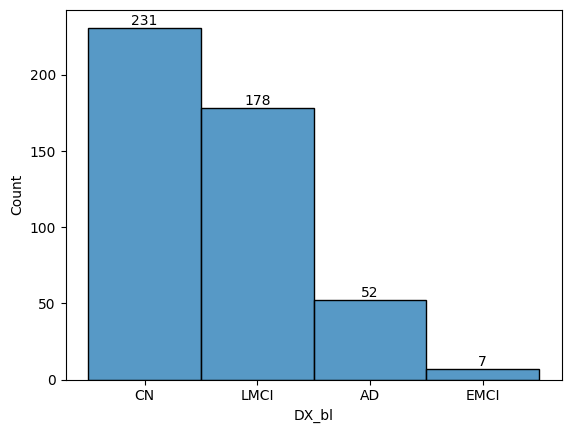

In [ ]:
# Baseline diagnosis

ax = sns.histplot(data['DX_bl'])

for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only label non-empty bins
        ax.text(patch.get_x() + patch.get_width() / 2,
                height,
                int(height),
                ha='center', va='bottom')

plt.savefig("baseline-dx.jpg")
plt.show()

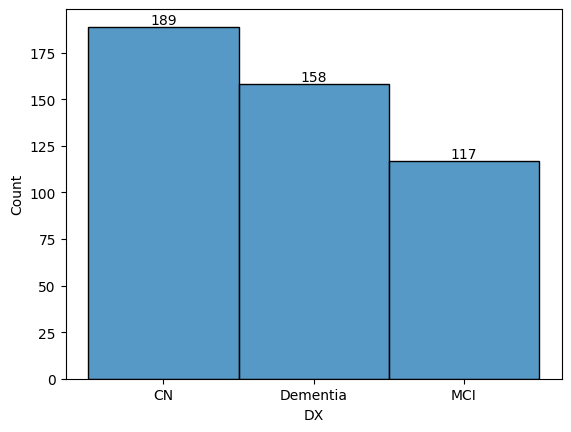

In [ ]:
# Last diagnosis DX

ax = sns.histplot(data['DX'])

for patch in ax.patches:
    height = patch.get_height()
    if height > 0:  # Only label non-empty bins
        ax.text(patch.get_x() + patch.get_width() / 2,
                height,
                int(height),
                ha='center', va='bottom')

plt.savefig("diagnosis.jpg")
plt.show()

The target variable DX is not completely balanced, with the Imbalance ratio being

$$\textbf{IR} = \frac{\text{largest class size}}{\text{smallest class size}} = \frac{189}{117} \approx 1.62$$

between classes CN and MCI. An imbalance between 1.5 and 2 is considered mild, and a possible solution include oversampling the less represented class or adding weights to the classes when defining the model.

### Missing values analysis

In [ ]:
# Missing values

print("NA values in baseline", np.sum(data['DX_bl'].isna()))
print("NA values in current", np.sum(data['DX'].isna()))

NA values in baseline 0
NA values in current 4


In [ ]:
na_mask = data['DX'].isna()
data['DX_bl'][na_mask]

,DX_bl
14,CN
207,CN
455,CN
457,CN


In [ ]:
metadata[['EXAMDATE_bl', 'EXAMDATE']][na_mask]

,EXAMDATE_bl,EXAMDATE
14,2011-10-25,2011-10-25
207,2011-09-07,2015-10-12
455,2011-08-29,2015-09-10
457,2011-12-07,2015-12-10


In [ ]:
# Drop NA diagnosis values

na_idx = np.argwhere(na_mask == True).flatten()
data.drop(na_idx, inplace=True)
metadata.drop(na_idx, inplace=True)

/tmp/ipython-input-542774056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.drop(na_idx, inplace=True)


Given that all missing target values were cognitive normal patients and the last update differs by multiple years from the baseline exam date, the diagnosis could have change throughout the years, therefore with the given information it is best if these samples are removed from the dataset.

### Feasible cases analysis

In [ ]:
# Changes in diagnosis

dif_idx = data['DX'] != data['DX_bl']
data[['DX_bl', 'DX']][dif_idx]

,DX_bl,DX
2,LMCI,Dementia
3,LMCI,MCI
5,LMCI,Dementia
7,LMCI,Dementia
9,LMCI,MCI
...,...,...
456,AD,Dementia
459,CN,MCI
461,CN,MCI
462,LMCI,MCI


Latest diagnosis (DX) should be equal or worse than the baseline diagnosis, given that unfortunately the disease still has no cure.

In [ ]:
# Check for impossible diagnosis (improving patients)
bl_mapping = {'CN': 'CN', 'EMCI': 'MCI', 'LMCI': 'MCI', 'AD': 'Dementia'}

impossible = list()
for i, (bl, cu) in enumerate(data[['DX_bl', 'DX']].values):
  bl = bl_mapping[bl]

  # Stable diagnosis
  if bl == cu:
    continue

  # Normal evolution
  elif (bl == 'CN' and (cu == 'MCI' or cu == 'Dementia')) or\
    (bl == 'MCI' and cu == 'Dementia'):
    continue

  # Impossible evolution
  else:
    print(i, bl, cu)
    impossible.append(i)

35 MCI CN
50 MCI CN
64 MCI CN
142 MCI CN
230 MCI CN
233 MCI CN
256 MCI CN
317 MCI CN
402 Dementia MCI
422 MCI CN
431 MCI CN


In [ ]:
# Drop impossible diagnosis values

data.drop(impossible, inplace=True)
metadata.drop(impossible, inplace=True)

/tmp/ipython-input-711397871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.drop(impossible, inplace=True)


In [ ]:
data

,DX_bl,AGE,PTEDUCAT,APOE4,FDG,PIB,AV45,FBB,ABETA,TAU,...,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_Asian,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Hawaiian/Other PI,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Never married,PTMARRY_Unknown
0,CN,84.8,18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,CN,89.6,16,0.0,1.33896,NaN,0.9884,NaN,1700.0,288.8,...,0,0,0,0,0,1,0,0,0,0
2,LMCI,65.1,16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,LMCI,57.8,20,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
4,CN,71.1,16,0.0,NaN,NaN,1.1024,NaN,1220.0,238.6,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,16,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
464,CN,70.9,15,0.0,NaN,NaN,1.0909,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
465,CN,80.3,20,0.0,1.10605,NaN,1.1131,NaN,1163.0,207.2,...,0,0,0,0,0,1,0,0,0,0
466,CN,76.5,16,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


# Explainatory Data Analysis

## Missing values

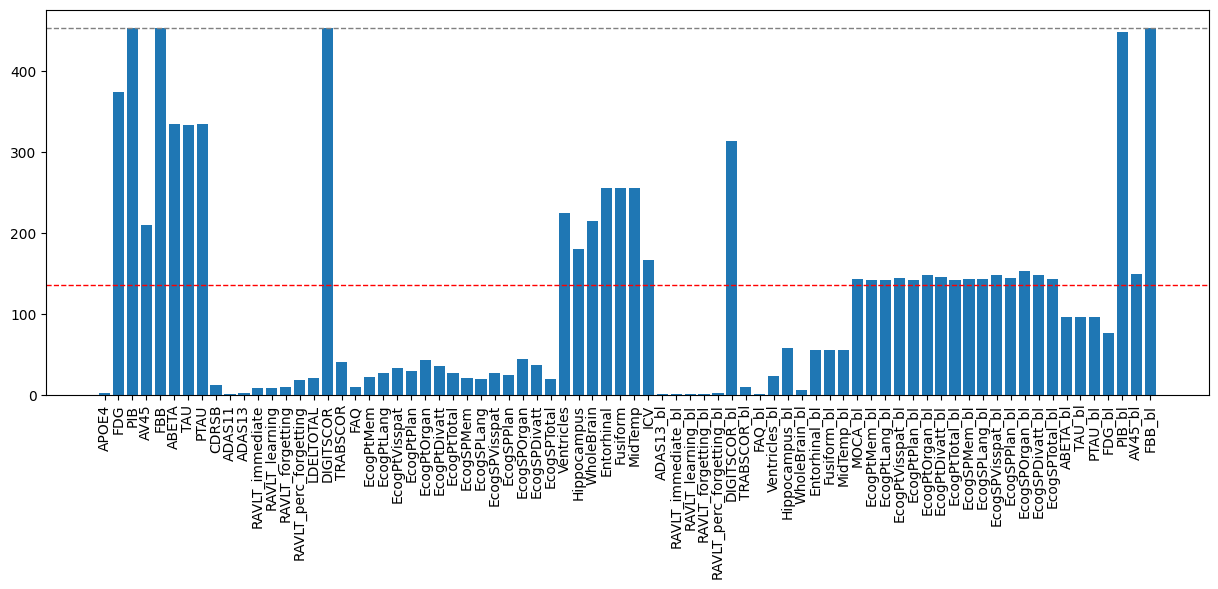

In [ ]:
# Missing values in features

total = len(data)
na_mask = np.array(data.isna().sum() > 0)
na_idx = (na_mask * np.array(range(len(na_mask))))[na_mask]

plt.figure(figsize=[15,5])
plt.bar(data.columns[na_idx], data.iloc[:, na_idx].isna().sum())
plt.axhline(y=total, color='gray', linestyle='--', linewidth=1)
plt.axhline(y=total*0.3, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=90)
plt.show()

Features with >30% missing values are removed.

In [ ]:
total = len(data)

na_mask = np.array(data.isna().sum() > 0.3*total)
na_idx = (na_mask * np.array(range(len(na_mask))))[na_mask]
data.drop(data.columns[na_idx], axis=1, inplace=True)
data

,DX_bl,AGE,PTEDUCAT,APOE4,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,...,PTRACCAT_Black,PTRACCAT_More than one,PTRACCAT_Asian,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Hawaiian/Other PI,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Never married,PTMARRY_Unknown
0,CN,84.8,18,1.0,0.0,7.0,9.0,2.0,22.0,41.0,...,0,0,0,0,0,1,0,0,0,0
1,CN,89.6,16,0.0,NaN,4.0,7.0,2.0,28.0,40.0,...,0,0,0,0,0,1,0,0,0,0
2,LMCI,65.1,16,1.0,5.0,29.0,39.0,9.0,24.0,24.0,...,0,0,0,0,0,1,0,0,0,0
3,LMCI,57.8,20,0.0,0.5,4.0,7.0,3.0,30.0,34.0,...,0,0,0,0,0,1,0,0,0,0
4,CN,71.1,16,0.0,0.0,8.0,13.0,5.0,29.0,50.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,16,1.0,0.0,7.0,8.0,1.0,28.0,46.0,...,0,0,0,0,0,0,0,0,1,0
464,CN,70.9,15,0.0,1.5,5.0,7.0,2.0,29.0,36.0,...,0,0,0,0,0,1,0,0,0,0
465,CN,80.3,20,0.0,0.0,6.0,10.0,2.0,30.0,49.0,...,0,0,0,0,0,1,0,0,0,0
466,CN,76.5,16,0.0,0.0,5.0,7.0,1.0,28.0,46.0,...,0,0,0,0,0,1,0,0,0,0


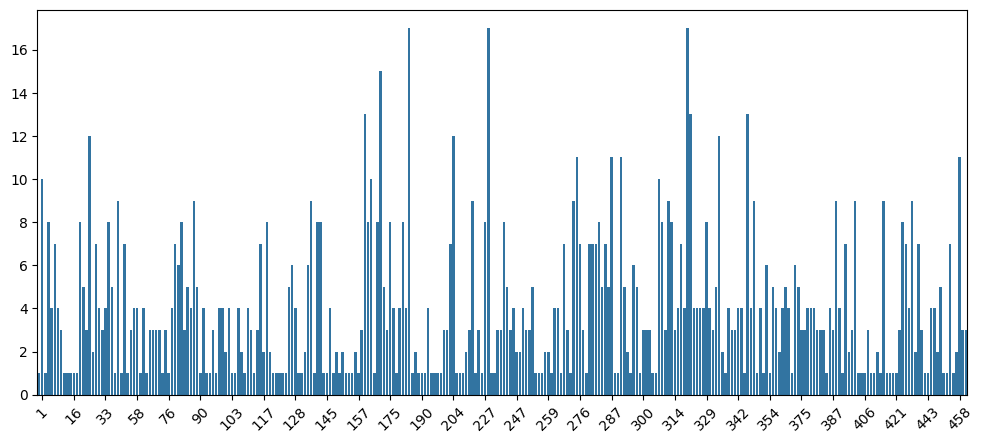

In [ ]:
# Missing values in samples

sample_na = np.sum(data.isna(), axis=1)
sample_na = sample_na[sample_na > 0]
length = sample_na.index

plt.figure(figsize=[12,5])
sns.barplot(sample_na)
plt.xticks(rotation=45)
step = 10
plt.xticks(np.arange(sample_na[0], len(sample_na)+1, step))
plt.show()

The higher missing feature value rate is lower than 1.6%, therefore no sample needs to be individually removed.

Features with <30% missing values are imputed using all available information from other features, following a KNN imputer.

In [ ]:
na_mask = np.array(data.isna().sum())
na_mask = (na_mask > 0) * (na_mask < 0.3*total)
na_idx = (na_mask * np.array(range(len(na_mask))))[na_mask]

data[data.columns[na_idx]]

,APOE4,CDRSB,ADAS11,ADAS13,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,TRABSCOR,...,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl
0,1.0,0.0,7.0,9.0,41.0,5.0,0.0,0.0000,14.0,107.0,...,39130.0,7068.0,1076350.0,3619.0,16561.0,19829.0,888.1,355.2,34.73,NaN
1,0.0,NaN,4.0,7.0,40.0,7.0,5.0,45.4545,15.0,73.0,...,39103.0,7194.0,989449.0,4201.0,13629.0,18673.0,1700.0,265.9,22.82,NaN
2,1.0,5.0,29.0,39.0,24.0,0.0,5.0,100.0000,0.0,143.0,...,16684.0,6107.0,927913.0,2511.0,18072.0,17213.0,957.8,316.9,31.69,NaN
3,0.0,0.5,4.0,7.0,34.0,3.0,8.0,100.0000,18.0,66.0,...,40063.0,NaN,1137850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,8.0,13.0,50.0,7.0,7.0,58.3333,12.0,142.0,...,32271.0,6261.0,1012400.0,2623.0,16949.0,19828.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1.0,0.0,7.0,8.0,46.0,11.0,10.0,71.4286,12.0,52.0,...,32916.0,6702.0,1076170.0,3579.0,19294.0,21906.0,NaN,NaN,NaN,1.26377
464,0.0,1.5,5.0,7.0,36.0,6.0,3.0,30.0000,20.0,92.0,...,24627.0,7754.0,1038440.0,4108.0,16927.0,20504.0,1635.0,209.9,19.56,1.52211
465,0.0,0.0,6.0,10.0,49.0,8.0,3.0,25.0000,17.0,137.0,...,58076.0,7223.0,1081780.0,4262.0,19527.0,18923.0,1264.0,202.6,17.29,1.15513
466,0.0,0.0,5.0,7.0,46.0,2.0,2.0,20.0000,15.0,59.0,...,31534.0,6812.0,955752.0,NaN,NaN,NaN,1700.0,277.0,23.97,1.30308


In [ ]:
# Encode target and create a copy of the data without categorical data
# for KNNImputer and correlation graphs

idx = (np.array(data.dtypes == 'object')*np.array(range(len(data.columns))))[list(data.dtypes == 'object')]
str_columns = data.columns[idx]

aux = list()
for row in data['DX']:
  if row == 'CN':
    aux.append(0)
  elif row=='MCI':
    aux.append(1)
  else:
    aux.append(2)
data['target'] = aux

no_str_data = data.drop(columns=str_columns)

In [ ]:
# To performe imputation, string variables must be set apart

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
aux_data = imputer.fit_transform(no_str_data)
no_str_data = pd.DataFrame(aux_data, columns=no_str_data.columns)

In [ ]:
no_str_data.index = data.index
data[no_str_data.columns] = no_str_data
data

,DX_bl,AGE,PTEDUCAT,APOE4,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,...,PTRACCAT_More than one,PTRACCAT_Asian,PTRACCAT_Am Indian/Alaskan,PTRACCAT_Hawaiian/Other PI,PTMARRY_Married,PTMARRY_Widowed,PTMARRY_Divorced,PTMARRY_Never married,PTMARRY_Unknown,target
0,CN,84.8,18.0,1.0,0.0,7.0,9.0,2.0,22.0,41.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,CN,89.6,16.0,0.0,3.0,4.0,7.0,2.0,28.0,40.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,LMCI,65.1,16.0,1.0,5.0,29.0,39.0,9.0,24.0,24.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
3,LMCI,57.8,20.0,0.0,0.5,4.0,7.0,3.0,30.0,34.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,CN,71.1,16.0,0.0,0.0,8.0,13.0,5.0,29.0,50.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,16.0,1.0,0.0,7.0,8.0,1.0,28.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
464,CN,70.9,15.0,0.0,1.5,5.0,7.0,2.0,29.0,36.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
465,CN,80.3,20.0,0.0,0.0,6.0,10.0,2.0,30.0,49.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
466,CN,76.5,16.0,0.0,0.0,5.0,7.0,1.0,28.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Sanity check

data.isna().sum().sum()

np.int64(0)

## Feature engineering

In [ ]:
# Add temporal features normalized by time
# Compute difference between baseline features and their latest value

variants = ['_BL', '_Bl', '_bl']

extract_year = lambda x: int(x[:4])
years_bl = np.array([extract_year(row) for row in list(metadata['EXAMDATE_bl'])])
years = np.array([extract_year(row) for row in list(metadata['EXAMDATE'])])
years_dif = years - years_bl

new_cols = list()
for col in data.columns:
  if ('_bl' in col.lower()) and ('_bla' not in col.lower()):
    if col == 'DX_bl':
      continue
    initial = data[col]
    for var in variants:
      label = col.split(var)
      if len(label) == 1:
        continue
      label = label[0]
      break
    if label not in data.columns:
      continue
    latest = data[label]
    dif_list = list()
    for dif, year in zip((latest - initial), years_dif):
      if year == 0:
        dif_list.append(0)
      else:
        dif_list.append(dif / year)

    dif_series = pd.Series(dif_list, name=f"{label}_dif")
    new_cols.append(dif_series)

new_cols = pd.concat(new_cols, axis=1)
new_cols.index = data.index
data = pd.concat([data] + [new_cols], axis=1)

In [ ]:
for col in data.columns:
  if col.endswith('_dif'):
    print(col)

CDRSB_dif
ADAS11_dif
ADAS13_dif
ADASQ4_dif
MMSE_dif
RAVLT_immediate_dif
RAVLT_learning_dif
RAVLT_forgetting_dif
RAVLT_perc_forgetting_dif
LDELTOTAL_dif
TRABSCOR_dif
FAQ_dif
mPACCdigit_dif
mPACCtrailsB_dif
Month_dif


In [ ]:
data

,DX_bl,AGE,PTEDUCAT,APOE4,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,...,RAVLT_immediate_dif,RAVLT_learning_dif,RAVLT_forgetting_dif,RAVLT_perc_forgetting_dif,LDELTOTAL_dif,TRABSCOR_dif,FAQ_dif,mPACCdigit_dif,mPACCtrailsB_dif,Month_dif
0,CN,84.8,18.0,1.0,0.0,7.0,9.0,2.0,22.0,41.0,...,-2.500000,0.000000,-0.500000,-3.846150,0.333333,-32.166667,0.000000,-1.209494,-0.456150,0.016400
1,CN,89.6,16.0,0.0,3.0,4.0,7.0,2.0,28.0,40.0,...,0.666667,0.333333,0.333333,2.020200,0.333333,1.000000,1.483333,-0.101684,-0.131959,-0.016400
2,LMCI,65.1,16.0,1.0,5.0,29.0,39.0,9.0,24.0,24.0,...,-2.000000,-0.571429,-0.571429,0.000000,-0.142857,10.000000,1.571429,-1.009547,-0.724479,-0.004686
3,LMCI,57.8,20.0,0.0,0.5,4.0,7.0,3.0,30.0,34.0,...,0.111111,-0.222222,0.222222,3.703700,1.444444,-0.444444,0.333333,0.906068,0.890073,-0.003667
4,CN,71.1,16.0,0.0,0.0,8.0,13.0,5.0,29.0,50.0,...,-0.625000,-0.250000,0.375000,3.958325,-0.625000,8.875000,0.000000,-0.701259,-0.710997,-0.364750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,16.0,1.0,0.0,7.0,8.0,1.0,28.0,46.0,...,-0.750000,0.750000,0.750000,5.357150,0.500000,-1.000000,0.000000,0.094602,0.114561,-0.024600
464,CN,70.9,15.0,0.0,1.5,5.0,7.0,2.0,29.0,36.0,...,-1.200000,0.200000,-0.400000,-3.090900,1.600000,-2.600000,0.000000,0.872486,0.717102,-0.163940
465,CN,80.3,20.0,0.0,0.0,6.0,10.0,2.0,30.0,49.0,...,7.000000,1.500000,-0.500000,-9.722200,1.000000,-10.500000,2.000000,2.095530,1.741447,-1.426250
466,CN,76.5,16.0,0.0,0.0,5.0,7.0,1.0,28.0,46.0,...,-1.750000,-2.000000,-0.750000,-4.615375,-0.250000,-34.500000,0.500000,-0.205270,0.561635,0.655750


The result is a dataset with 1006 columns and 453 rows. Given that there are more columns than samples, a selection of features must be performed.

## Feature selection and correlations

In [ ]:
# Remove features with a single value (threshold 1e-10)

from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-10)
X_reduced = vt.fit_transform(no_str_data)
kept_columns = no_str_data.columns[vt.get_support()]
print('Original nº columns:', len(data.columns),
      '\nSelected nº columns:', len(kept_columns) + len(str_columns))

Original nº columns: 1006 
Selected nº columns: 956


In [ ]:
static_cols = list()
for col in no_str_data.columns:
  if col not in kept_columns:
    print(col, data[col].unique())
    static_cols.append(col)

data.drop(columns=static_cols, inplace=True)
no_str_data.drop(columns=static_cols, inplace=True)

aseg+DKT.stats-CC_Posterior-NVoxels [0.]
aseg+DKT.stats-CC_Posterior-Volume_mm3 [0.]
aseg+DKT.stats-CC_Posterior-normMean [0.]
aseg+DKT.stats-CC_Posterior-normStdDev [0.]
aseg+DKT.stats-CC_Posterior-normMin [0.]
aseg+DKT.stats-CC_Posterior-normMax [0.]
aseg+DKT.stats-CC_Posterior-normRange [0.]
aseg+DKT.stats-CC_Mid_Posterior-NVoxels [0.]
aseg+DKT.stats-CC_Mid_Posterior-Volume_mm3 [0.]
aseg+DKT.stats-CC_Mid_Posterior-normMean [0.]
aseg+DKT.stats-CC_Mid_Posterior-normStdDev [0.]
aseg+DKT.stats-CC_Mid_Posterior-normMin [0.]
aseg+DKT.stats-CC_Mid_Posterior-normMax [0.]
aseg+DKT.stats-CC_Mid_Posterior-normRange [0.]
aseg+DKT.stats-CC_Central-NVoxels [0.]
aseg+DKT.stats-CC_Central-Volume_mm3 [0.]
aseg+DKT.stats-CC_Central-normMean [0.]
aseg+DKT.stats-CC_Central-normStdDev [0.]
aseg+DKT.stats-CC_Central-normMin [0.]
aseg+DKT.stats-CC_Central-normMax [0.]
aseg+DKT.stats-CC_Central-normRange [0.]
aseg+DKT.stats-CC_Mid_Anterior-NVoxels [0.]
aseg+DKT.stats-CC_Mid_Anterior-Volume_mm3 [0.]
aseg+DK

Features with correlations close to 1 or -1 complicate linear models to determine their individual contributions, which can lead to unstable coefficients and inflated variances, harming interpretability and generalization.

Additionally, for tree models, it adds unnecessary complexity, more time and overfitting because of redundancy. Also, it dilutes feature importance scores, making interpretation harder

In [ ]:
# Check features with correlations too close to 1 or -1

threshold = 0.9
corrs = no_str_data.corr()

combinations = list()
for i, col in enumerate(no_str_data.columns):
    for j, row in enumerate(no_str_data.columns):
        if i == j:
            break
        val = corrs[col][row]
        if (col != row) and (1 - np.abs(val) < 1 - threshold):
            combinations.append((col, row, val))

print(len(combinations), 'close correlations:')
pprint.pprint(combinations)

820 close correlations:
[('ADAS13', 'ADAS11', np.float64(0.9855218106148296)),
 ('MMSE', 'ADAS11', np.float64(-0.904433435338316)),
 ('MMSE', 'ADAS13', np.float64(-0.9048089104418909)),
 ('MOCA', 'ADAS11', np.float64(-0.9003040882609067)),
 ('MOCA', 'ADAS13', np.float64(-0.9091448370483116)),
 ('EcogPtTotal', 'EcogPtLang', np.float64(0.9072560632122223)),
 ('EcogSPVisspat', 'FAQ', np.float64(0.9058077650585895)),
 ('EcogSPPlan', 'EcogSPVisspat', np.float64(0.9271678620761433)),
 ('EcogSPTotal', 'FAQ', np.float64(0.9001936133918987)),
 ('EcogSPTotal', 'EcogSPMem', np.float64(0.9514918381562948)),
 ('EcogSPTotal', 'EcogSPLang', np.float64(0.9472778345138728)),
 ('EcogSPTotal', 'EcogSPVisspat', np.float64(0.9481737952883539)),
 ('EcogSPTotal', 'EcogSPPlan', np.float64(0.9542644547264478)),
 ('EcogSPTotal', 'EcogSPOrgan', np.float64(0.9299787896212124)),
 ('EcogSPTotal', 'EcogSPDivatt', np.float64(0.9326489955234121)),
 ('mPACCdigit', 'ADAS11', np.float64(-0.9186089296195408)),
 ('mPACCdig

Observations:
- All cognivite tests are closely related (>0.9), which is expected because they are constructed to measure similar aspects of the patient cognition. The most relevant of them all according to model importance is CDR-SB, therefore $\rightarrow$ **Only keep CDR-SB**
- Similarly, baseline cognitive tests are closely related. In this case not all of them, but instead separately ADAS13_bl and ADAS11_bl, mPACCtrailsB_bl and mPACCdigit_bl. $→$ **Only keep ADAS13_bl and mPACCtrialsB_bl**
- The baseline biomarkers measuring the concentration of TAU and phospho-TAU in CSF show a close relation between them (>0.97). **Keep both**
- Features M, Month, Month_bl and Years_bl are all closely related as they indicate the time duration between the tests. Only 1 of them should be kept $\rightarrow$ **Only keep Years_bl**
- FastSurfer's features based on NVoxels and Volume_mm3 are closely related between all brain parts because one is consequence of the other. For more precision, the features that will be kept are the ending in $\rightarrow$ **Only keep Volume_mm3**
- Some FastSurfer statistical features are closely related between left and right hemispheres $\rightarrow$ **Keep both**
- The feature PTGENDER that was previously encoded into male and female columns is completely negatively correlated, one must be removed $\rightarrow$ **Only keep PTGENDER_Female**
- Similarly, the feature PTETHCAT was encoded into Hisp/Latino, Not Hisp/Latino and Unknown. This last category has only a small representation, making the first two highly correlated, so one must be removed $→$ **Remove PTETHCAT_Not Hisp/Latino**


In [ ]:
# Correlation removal

redundant = [
    'ADAS11', 'ADAS13', 'MMSE', 'FAQ', 'MOCA', 'ADAS11_bl', 'mPACCdigit_bl',
      'mPACCdigit',
    'EcogPtVisspat', 'EcogPtMem', 'EcogPtPlan', 'EcogPtLang', 'EcogPtOrgan',
      'EcogPtDivatt',
    'EcogSPVisspat', 'EcogSPMem', 'EcogSPPlan', 'EcogSPLang', 'EcogSPOrgan',
      'EcogSPDivatt',
    'M', 'Month', 'Month_bl',
    'PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino'
    ]

for col in data.columns:
    if (col.startswith('aseg') or col.startswith('cerebellum')) and \
      (col.endswith('NVoxels')):
      redundant.append(col)

data.drop(columns=redundant, inplace=True)
no_str_data.drop(columns=redundant, inplace=True)

In [ ]:
data

,DX_bl,AGE,PTEDUCAT,APOE4,CDRSB,ADASQ4,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,...,RAVLT_immediate_dif,RAVLT_learning_dif,RAVLT_forgetting_dif,RAVLT_perc_forgetting_dif,LDELTOTAL_dif,TRABSCOR_dif,FAQ_dif,mPACCdigit_dif,mPACCtrailsB_dif,Month_dif
0,CN,84.8,18.0,1.0,0.0,2.0,41.0,5.0,0.0,0.0000,...,-2.500000,0.000000,-0.500000,-3.846150,0.333333,-32.166667,0.000000,-1.209494,-0.456150,0.016400
1,CN,89.6,16.0,0.0,3.0,2.0,40.0,7.0,5.0,45.4545,...,0.666667,0.333333,0.333333,2.020200,0.333333,1.000000,1.483333,-0.101684,-0.131959,-0.016400
2,LMCI,65.1,16.0,1.0,5.0,9.0,24.0,0.0,5.0,100.0000,...,-2.000000,-0.571429,-0.571429,0.000000,-0.142857,10.000000,1.571429,-1.009547,-0.724479,-0.004686
3,LMCI,57.8,20.0,0.0,0.5,3.0,34.0,3.0,8.0,100.0000,...,0.111111,-0.222222,0.222222,3.703700,1.444444,-0.444444,0.333333,0.906068,0.890073,-0.003667
4,CN,71.1,16.0,0.0,0.0,5.0,50.0,7.0,7.0,58.3333,...,-0.625000,-0.250000,0.375000,3.958325,-0.625000,8.875000,0.000000,-0.701259,-0.710997,-0.364750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,CN,72.4,16.0,1.0,0.0,1.0,46.0,11.0,10.0,71.4286,...,-0.750000,0.750000,0.750000,5.357150,0.500000,-1.000000,0.000000,0.094602,0.114561,-0.024600
464,CN,70.9,15.0,0.0,1.5,2.0,36.0,6.0,3.0,30.0000,...,-1.200000,0.200000,-0.400000,-3.090900,1.600000,-2.600000,0.000000,0.872486,0.717102,-0.163940
465,CN,80.3,20.0,0.0,0.0,2.0,49.0,8.0,3.0,25.0000,...,7.000000,1.500000,-0.500000,-9.722200,1.000000,-10.500000,2.000000,2.095530,1.741447,-1.426250
466,CN,76.5,16.0,0.0,0.0,1.0,46.0,2.0,2.0,20.0000,...,-1.750000,-2.000000,-0.750000,-4.615375,-0.250000,-34.500000,0.500000,-0.205270,0.561635,0.655750


In [ ]:
# Class accuracy function

def per_class_accuracy(y_true, y_pred):
    labels = {0: 'CN', 1: 'MCI', 2: 'AD'}
    acc_dict = {}

    for val, name in labels.items():
        mask = (y_true == val)
        if np.sum(mask) == 0:
            acc = 0
        else:
            acc = np.mean(y_pred[mask] == y_true[mask])
        acc_dict[name] = acc

    return acc_dict

In [ ]:
# Train XGBoost with k fold and retreive the most common features in the top
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

target = ['DX', 'DX_bl', 'target']

X = data.drop(columns=target)
y = data['target']

kf = KFold(n_splits=10, shuffle=True)

accs = list()
fold_results = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")

    # compute class weights for the fold
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )

    # create and fit model instance
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=10,
        objective='multi:softmax')

    bst.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        sample_weight=classes_weights)

    # validate results
    preds = bst.predict(X.iloc[test_index])
    acc = per_class_accuracy(y.iloc[test_index], preds)
    print(acc)
    accs.append(acc)

    # get feature importance
    feature_important = bst.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    s = pd.Series(values, index=keys, name=f"fold{i}")
    fold_results.append(s)

# collect and sum across folds
scores = pd.concat(fold_results, axis=1).fillna(0)
scores['total_importance'] = scores.sum(axis=1)

scores = scores['total_importance'] \
              .sort_values(ascending=False) \
              .to_frame()

Fold 0:
{'CN': np.float64(0.8636363636363636), 'MCI': np.float64(0.8), 'AD': np.float64(1.0)}
Fold 1:
{'CN': np.float64(0.8), 'MCI': np.float64(0.875), 'AD': np.float64(1.0)}
Fold 2:
{'CN': np.float64(0.88), 'MCI': np.float64(0.6363636363636364), 'AD': np.float64(1.0)}
Fold 3:
{'CN': np.float64(0.7857142857142857), 'MCI': np.float64(0.7058823529411765), 'AD': np.float64(0.8571428571428571)}
Fold 4:
{'CN': np.float64(0.9411764705882353), 'MCI': np.float64(0.8461538461538461), 'AD': np.float64(0.9333333333333333)}
Fold 5:
{'CN': np.float64(1.0), 'MCI': np.float64(0.8571428571428571), 'AD': np.float64(1.0)}
Fold 6:
{'CN': np.float64(1.0), 'MCI': np.float64(0.6875), 'AD': np.float64(1.0)}
Fold 7:
{'CN': np.float64(0.8235294117647058), 'MCI': np.float64(0.8), 'AD': np.float64(0.8888888888888888)}
Fold 8:
{'CN': np.float64(0.8888888888888888), 'MCI': np.float64(0.7272727272727273), 'AD': np.float64(0.875)}
Fold 9:
{'CN': np.float64(0.9411764705882353), 'MCI': np.float64(0.6666666666666666), 

In [ ]:
# We select features with at least score 10 (to avoid outliers)

val = np.array(scores)
no_outliers = np.argwhere(val > 9)[:,0]
scores.iloc[no_outliers]

,total_importance
CDRSB,803.0
mPACCtrailsB,410.0
LDELTOTAL_BL,378.0
EcogSPTotal,279.0
CDRSB_bl,213.0
...,...
aseg+DKT.stats-ctx-rh-caudalanteriorcingulate-normRange,10.0
cerebellum.CerebNet.stats-Cbm_Right_CrusII-normRange,10.0
aseg+DKT.stats-ctx-rh-superiortemporal-normRange,10.0
aseg+DKT.stats-ctx-rh-precentral-normMean,10.0


In [ ]:
# Final feature selection (around 210 features)

selected_columns = scores.iloc[no_outliers].index
data = data[selected_columns].copy()
data['target'] = y
data

,CDRSB,mPACCtrailsB,LDELTOTAL_BL,EcogSPTotal,CDRSB_bl,EcogPtTotal,CDRSB_dif,LDELTOTAL,RAVLT_immediate,mPACCtrailsB_bl,...,MMSE_bl,aseg+DKT.stats-ctx-rh-lateralorbitofrontal-normMax,aseg+DKT.stats-ctx-rh-isthmuscingulate-normMin,aseg+DKT.stats-ctx-rh-inferiorparietal-Volume_mm3,aseg+DKT.stats-ctx-rh-caudalanteriorcingulate-normRange,cerebellum.CerebNet.stats-Cbm_Right_CrusII-normRange,aseg+DKT.stats-ctx-rh-superiortemporal-normRange,aseg+DKT.stats-ctx-rh-precentral-normMean,APOE4,target
0,0.0,-6.372790,12.0,1.102560,0.0,1.05128,0.000000,14.0,41.0,-3.635890,...,28.0,103.0,58.0,10575.018,53.0,69.0,50.0,80.1741,1.0,0.0
1,3.0,0.070526,13.0,2.219971,0.0,1.43590,0.500000,15.0,40.0,0.862282,...,30.0,114.0,52.0,9726.136,43.0,81.0,53.0,84.3470,0.0,0.0
2,5.0,-13.413300,1.0,2.864860,0.5,1.21622,0.642857,0.0,24.0,-8.341950,...,27.0,123.0,50.0,9055.514,47.0,76.0,59.0,80.6010,1.0,2.0
3,0.5,2.397160,5.0,1.435900,1.5,1.66667,-0.111111,18.0,34.0,-5.613500,...,28.0,106.0,53.0,14162.281,53.0,64.0,53.0,77.5413,0.0,1.0
4,0.0,-3.206340,17.0,1.200000,0.0,1.76316,0.000000,12.0,50.0,2.481640,...,30.0,107.0,49.0,10964.810,44.0,67.0,49.0,81.1170,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.0,0.528008,10.0,1.270270,0.0,1.25641,0.000000,12.0,46.0,0.069766,...,29.0,110.0,54.0,12388.049,50.0,70.0,50.0,79.8493,1.0,0.0
464,1.5,1.894840,12.0,2.076920,0.0,1.46154,0.300000,20.0,36.0,-1.690670,...,28.0,103.0,48.0,9128.559,51.0,69.0,50.0,81.5149,0.0,0.0
465,0.0,0.921904,15.0,1.473680,0.0,1.02564,0.000000,17.0,49.0,-2.560990,...,29.0,104.0,52.0,11619.665,64.0,73.0,55.0,80.5949,0.0,0.0
466,0.0,1.130220,16.0,1.128210,0.0,1.00000,0.000000,15.0,46.0,-1.116320,...,29.0,110.0,52.0,9322.552,55.0,66.0,51.0,79.4321,0.0,0.0


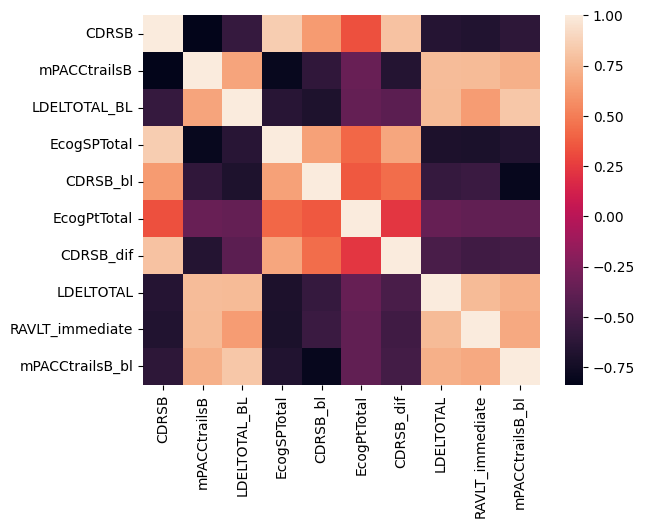

In [ ]:
# Correlation between the 10 most important features
sns.heatmap(data.iloc[:,:10].corr())
plt.savefig('correlation.jpg', bbox_inches='tight', dpi=300)
plt.show()

## Translate features into natural language

First, the FastSurfer variables

In [ ]:
# URL to FreeSurferColorLUT for region codes
LUT_URL = (
    'https://raw.githubusercontent.com/freesurfer/freesurfer/dev/'
    'distribution/FreeSurferColorLUT.txt'
)

# Load the LUT into a DataFrame with robust parsing (handles extra columns)
def load_lut(url=LUT_URL):
    response = requests.get(url)
    response.raise_for_status()
    lines = response.text.splitlines()

    records = []
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        # Split into at most 6 fields: ID, Label, R, G, B, A; ignore extras
        parts = line.split(None, 5)
        if len(parts) < 6:
            continue
        region_id, label, r, g, b, a = parts[:6]
        records.append({'Label': label, 'ID': int(region_id)})

    df = pd.DataFrame(records)
    return df.set_index('Label')

lut = load_lut()

# Mapping of metric suffixes to natural-language descriptions
METRIC_MAP = {
    'normMean':    'Average normalized intensity',
    'normStdDev':  'Standard deviation of the normalized intensity',
    'normMin':     'Minimum normalized intensity',
    'normMax':     'Maximum normalized intensity',
    'normRange':   'Range of the normalized intensity',
    'NumVert':     'Number of vertices in the region',
    'SurfArea_mm2':'Surface area in square millimeters',
    'GrayVol_mm3': 'Gray-matter volume in cubic millimeters',
    'ThickAvg':    'Average cortical thickness in millimeters',
    'ThickStd':    'Standard deviation of cortical thickness',
    'Meancurv':    'Mean curvature of the surface',
    'Gauscurv':    'Gaussian curvature of the surface',
    'FoldInd':     'Folding index of the cortex',
    'Curvind':     'Curvature index',
    'NVoxels':     'Number of voxels in the structure',
    'Volume_mm3':  'Volume in cubic millimeters',
}

# Helpers for region-code interpretation
HEMISPHERE_MAP = {'lh': 'left hemisphere', 'rh': 'right hemisphere'}
PREFIX_MAP = {'ctx': 'cortical region', 'aseg': 'subcortical structure'}


def describe_fs_feature(feature_name: str) -> str:
    """
    Given a FastSurfer/FreeSurfer feature name (aseg or cortical), returns a natural-language description.
    Handles formats like:
      - aseg+DKT.stats-Left-Cerebral-White-Matter-normMean
      - aseg+DKT.stats-ctx-rh-postcentral-normStdDev
      - cerebellum.CerebNet.stats-Cbm_Left_VIIb-normMin
    """
    # remove file prefix up through 'stats-'
    if 'stats-' in feature_name:
        name = feature_name.split('stats-', 1)[1]
    else:
        name = feature_name
    parts = name.split('-')
    if len(parts) < 2:
        raise ValueError(f"Unexpected feature format: {feature_name}")

    # metric is always last part
    metric_key = parts[-1]
    metric_desc = METRIC_MAP.get(metric_key, metric_key.replace('_', ' '))

    # region parts are everything before metric
    region_parts = parts[:-1]

    # separate underscore cases like Cbm_Left_VIIIa
    if len(region_parts) == 1:
        region_parts = region_parts[0].split('_')
        if len(region_parts) == 4:
            region_parts[2] = f'{region_parts[2]}_{region_parts[3]}'

    # detect hemisphere for aseg features (Left/Right)
    hemi_desc = None
    if region_parts[0] in ['Left', 'Right']:
        hemi_desc = region_parts[0].lower() + ' hemisphere'
        region_parts = region_parts[1:]
    # detect cortex prefix for cortical stats
    elif region_parts[0] == 'ctx':
        # format 'ctx','lh'/'rh',regionname...
        hemi_code = region_parts[1]
        hemi_desc = HEMISPHERE_MAP.get(hemi_code, hemi_code)
        # drop first two parts
        region_parts = region_parts[2:]
    # cerebellum region
    elif region_parts[0] == 'Cbm':
        hemi_desc = region_parts[1].lower()
        if hemi_desc in ['right', 'left']:
            hemi_desc += ' hemisphere'
        if len(region_parts) == 3:
            region_parts = ['Cerebellum'] + [region_parts[2]]
        else:
            region_parts = ['Cerebellum']

    # build human-readable region name
    human_region = ' '.join(region_parts)

    # describe region type
    if feature_name.startswith('aseg'):
        region_type = 'subcortical structure'
    else:
        region_type = 'region'

    # assemble phrase
    phrase = f"{metric_desc} of the {human_region} {region_type}"
    if hemi_desc:
        phrase += f" in the {hemi_desc}"
    phrase += '.'
    return phrase

In [ ]:
example = 'aseg+DKT.stats-ctx-rh-postcentral-NVoxels'
example = 'cerebellum.CerebNet.stats-Cbm_Vermis_X-normRange'
print(describe_fs_feature(example))

Range of the normalized intensity of the Cerebellum X region in the vermis.


Then repeat for the ADNI and the rest of MRI variables and join

In [ ]:
FEATURE_MAP = {
    # Baseline diagnosis (handled separately), diagnosis
    'DX':                'Diagnosis category (e.g. Cognitively Normal, Mild Cognitive Impairment, Alzheimer\'s Disease)',
    # Demographics
    'AGE':               'Age in years at time of visit',
    'PTGENDER':          'Biological sex of participant',
    'PTEDUCAT':          'Years of formal education completed',
    'PTETHCAT':          'Self-reported ethnicity category',
    'PTRACCAT':          'Self-reported race category',
    'PTMARRY':           'Marital status of participant',
    # Genetics
    'APOE4':             'Number of APOE ε4 alleles (0, 1, or 2)',
    # PET & FDG imaging biomarkers
    'FDG':               'Global FDG PET standardized uptake value ratio',
    'PIB':               'Pittsburgh Compound B PET standardized uptake value ratio',
    'AV45':              'Florbetapir (AV45) PET standardized uptake value ratio',
    'FBB':               'Florbetaben PET standardized uptake value ratio',
    # CSF biomarkers
    'ABETA':             'Cerebrospinal fluid Aβ42 concentration (pg/mL)',
    'TAU':               'Cerebrospinal fluid total tau concentration (pg/mL)',
    'PTAU':              'Cerebrospinal fluid phosphorylated tau concentration (pg/mL)',
    # Cognitive & Clinical scales
    'CDRSB':             'Clinical Dementia Rating sum-of-boxes score',
    'ADAS11':            'ADAS-Cog 11-item cognitive subscale score',
    'ADAS13':            'ADAS-Cog 13-item cognitive subscale score',
    'ADASQ4':            'ADAS-Cog Question 4 severity score',
    'MMSE':              'Mini-Mental State Examination total score',
    'RAVLT_immediate':   'Rey Auditory Verbal Learning Test immediate recall score',
    'RAVLT_learning':    'Rey Auditory Verbal Learning Test learning score',
    'RAVLT_forgetting':  'Rey Auditory Verbal Learning Test forgetting score',
    'RAVLT_perc_forgetting': 'Percentage of words forgotten on RAVLT',
    'LDELTOTAL':         'Logical Memory Delayed Recall total score',
    'DIGITSCOR':         'Digit Span backward total score',
    'TRABSCOR':          'Trail Making Test B completion time (seconds)',
    'FAQ':               'Functional Activities Questionnaire total score',
    'MOCA':              'Montreal Cognitive Assessment total score',
    'mPACCdigit':        "ADNI‐modified Preclinical Alzheimer's Cognitive Composite with the Digit Symbol Substitution score",
    'mPACCtrailsB':      "ADNI‐modified Preclinical Alzheimer's Cognitive Composite with the Trail Making Test Part B completion time",
    # Everyday cognition (patient & study partner)
    'EcogPtMem':         'Everyday cognition: patient-reported memory function score',
    'EcogPtLang':        'Everyday cognition: patient-reported language function score',
    'EcogPtVisspat':     'Everyday cognition: patient-reported visuospatial function score',
    'EcogPtPlan':        'Everyday cognition: patient-reported planning function score',
    'EcogPtOrgan':       'Everyday cognition: patient-reported organization function score',
    'EcogPtDivatt':      'Everyday cognition: patient-reported divided attention score',
    'EcogPtTotal':       'Everyday cognition: patient-reported total score',
    'EcogSPMem':         'Everyday cognition: study partner-reported memory function score',
    'EcogSPLang':        'Everyday cognition: study partner-reported language function score',
    'EcogSPVisspat':     'Everyday cognition: study partner-reported visuospatial function score',
    'EcogSPPlan':        'Everyday cognition: study partner-reported planning function score',
    'EcogSPOrgan':       'Everyday cognition: study partner-reported organization function score',
    'EcogSPDivatt':      'Everyday cognition: study partner-reported divided attention score',
    'EcogSPTotal':       'Everyday cognition: study partner-reported total score',
    # MRI volumetrics and cortical thickness
    'Ventricles':        'Ventricle volume (mm³)',
    'Hippocampus':       'Hippocampal volume (mm³)',
    'WholeBrain':        'Whole brain volume (mm³)',
    'Entorhinal':        'Entorhinal cortex thickness (mm)',
    'Fusiform':          'Fusiform gyrus thickness (mm)',
    'MidTemp':           'Middle temporal gyrus thickness (mm)',
    'ICV':               'Intracranial volume (mm³)',
    # Temporal variables
    'Years':             'Years since baseline visit',
    'Month':             'Months since baseline visit',
    'M':                 'Months since basline visit',
    # Time difference
    'time_difference':   'Time difference between visits (days)'
}


def describe_feature(feature_name: str) -> str:
    """
    Given a feature name, returns a natural-language description.
    """

    if feature_name.startswith('aseg') or feature_name.startswith('cere'):
        desc = describe_fs_feature(feature_name)
        if desc is None:
            print(f' ## None Error: {feature_name}')
        return desc

    desc = ''

    # Baseline features
    idx = feature_name.lower().find('_bl')
    if idx != -1:
        if len(feature_name) > idx+3:
            # Avoid features with _Black or similar
            if feature_name[idx+3] == '_':
              feature_name = feature_name[:idx] + feature_name[idx+3:]
              desc = 'Baseline '
        else:
            feature_name = feature_name[:idx]
            desc = 'Baseline '

    # Evolution features
    if feature_name.endswith('_dif'):
        feature_name = feature_name[:-4]
        desc = 'Yearly evolution of '

    if FEATURE_MAP.get(feature_name) is None:
        # One-hot encodings
        idx = feature_name.find('_')
        if idx != -1:
            if not desc:
                desc = f'{feature_name[idx+1:]}-valued '
            else:
                desc += f'{feature_name[idx+1:]}-valued '
            feature_name = feature_name[:idx]

    if not desc:
        desc = FEATURE_MAP.get(feature_name)
    else:
        desc += FEATURE_MAP.get(feature_name)


    if desc is None:
        print(f' ## None Error: {feature_name}')
    return desc

example = 'mPACCtrailsB_dif'
print(describe_feature(example))

Yearly evolution of ADNI‐modified Preclinical Alzheimer's Cognitive Composite with the Trail Making Test Part B completion time


##Compute expected ranges

In [ ]:
# Extract expected ranges
data_cn = data[data['target'] == 0]
with open("norm_range.csv", "w") as f:
    for col in data_cn.columns:
        if col == 'target':
            continue
        mean_cn = np.mean(data_cn[col])
        std_cn = np.std(data_cn[col])

        # Bounds are mean +- std (or min max)
        lower = mean_cn - std_cn
        lower = lower if lower > np.min(data_cn[col]) else np.min(data_cn[col])
        upper = mean_cn + std_cn
        upper = upper if upper < np.max(data_cn[col]) else np.max(data_cn[col])

        f.write(f'{col};{lower:.2f};{upper:.2f}\n')

#Models

In a medical problem like this, it is preferable to make an error type I, which means wrongly diagnosing a patient with the disease. The other option, an error type II, would mean not diagnosing a patient that actually has the disease, which causes the patient to not receive the proper treatment and can be fatal.

In [ ]:
# Train-test split for model training
from sklearn.model_selection import train_test_split

X = data.drop(columns='target')
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Decision Tree

###Hyperparameter search

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

def kfold_validation(min_samples_leaf=0.05, max_depth=5):
    t0 = time.time()
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    accs = list()
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Create and fit model instance
        model_dt = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced",
            random_state=0
        )
        model_dt.fit(
            X.iloc[train_index],
            y.iloc[train_index])

        # Validate results
        preds = model_dt.predict(X.iloc[test_index])
        acc = per_class_accuracy(y.iloc[test_index], preds)
        accs.append(acc)
    return np.mean([np.mean(list(dic.values())) for dic in accs]), time.time() - t0

In [ ]:
# Perform hyperparameter search
def perform_hyperparameter_search(kfold_validation, performance_file, parameters):
    performance = list()
    parameters_names = list(parameters.keys())
    parameters_values = list(parameters.values())

    # Read the file if it exists
    try:
        with open(performance_file, 'r') as f:
            for line in f:
                performance.append(ast.literal_eval(line))

    # Perform hyperparameter search otherwise
    except FileNotFoundError:
        for p0 in parameters_values[0]:
            for p1 in parameters_values[1]:
                print(f"## {p0} {parameters_names[0]}, {p1} {parameters_names[1]}")
                accs = list()
                times = list()
                for _ in range(10):
                    acc, total_t = kfold_validation(p0, p1)
                    accs.append(acc)
                    times.append(total_t)
                print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
                print(f"Time: {np.mean(times):.3f} ± {np.std(times):.3f}s")

                run_summary = {
                    parameters_names[0]: p0,
                    parameters_names[1]: p1,
                    'accuracy': [float(str(f'{acc:.3f}')) for acc in accs],
                    'time': [float(str(f'{tim:.3f}')) for tim in times]
                }
                performance.append(run_summary)

        with open(performance_file, 'w') as f:
            for run in performance:
                f.write(str(run) + '\n')
    return performance

parameters = {'min_samples_leaf': [0.001, 0.02, 0.05, 0.1],
              'max_depth': [2, 3, 5, 10]}
performance = perform_hyperparameter_search(
    kfold_validation, 'performance_dt.txt', parameters)

In [ ]:
# Visualize the hyperparameter search
import plotly.graph_objects as go

def plot_hyperparameter_accuracy(performance, parameters):
    params_keys = list(parameters.keys())
    params_name = list(parameters.values())
    performance_df = pd.DataFrame(performance)

    params_unique = [np.unique(performance_df[key]) for key in params_keys]
    accuracies = np.array([np.mean(acc) for acc in performance_df['accuracy']])
    Z = accuracies.reshape(len(params_unique[0]), len(params_unique[1]))

    # Create the surface trace
    surface = go.Surface(
        x=params_unique[1],
        y=params_unique[0],
        z=Z,
        contours = {
            "z": {"show": True, "start": Z.min(), "end": Z.max(), "size": 0.002}
        }
    )

    # Build the figure
    fig = go.Figure(data=[surface])
    fig.update_layout(
        title="Hyperparameter Search Surface",
        scene=dict(
            xaxis_title=params_name[1],
            yaxis_title=params_name[0],
            zaxis_title="Accuracy"
        ),
        autosize=True
    )

    fig.show()

parameters = {"min_samples_leaf": "Min ratio of leaf samples",
              "max_depth": "Max depth"}
plot_hyperparameter_accuracy(performance, parameters)

In [ ]:
def plot_hyperparameter_time(performance, parameters):
    params_keys = list(parameters.keys())
    params_name = list(parameters.values())
    performance_df = pd.DataFrame(performance)

    params_unique = [np.unique(performance_df[key]) for key in params_keys]
    times = np.array([np.mean(tim) for tim in performance_df['time']])
    T = times.reshape(len(params_unique[0]), len(params_unique[1]))

    # Create the surface trace
    surface = go.Surface(
        x=params_unique[1],
        y=params_unique[0],
        z=T,
        contours = {
            "z": {"show": True, "start": T.min(), "end": T.max(), "size": 5}
        }
    )

    # Build the figure
    fig = go.Figure(data=[surface])
    fig.update_layout(
        title="Hyperparameter Search Surface",
        scene=dict(
            xaxis_title=params_name[1],
            yaxis_title=params_name[0],
            zaxis_title="Time"
        ),
        autosize=True
    )

    fig.show()

plot_hyperparameter_time(performance, parameters)

The best performing parameter combination is a max depth of 5 and a minimum ratio of leaf samples of 0.05. This combination avoids overfitting and the trees getting to specific, favouring generalization and performance.

###Metrics

In [ ]:
# KFold validation to extract robust metrics
from sklearn.metrics import confusion_matrix

kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    t0 = time.time()
    # Train model on that subset
    clf = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=0.05,
        class_weight="balanced",
        random_state=0)
    clf.fit(X.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")

Average training time: 0.05 ± 0.00s
Normalized accuracy: 0.83 ± 0.05


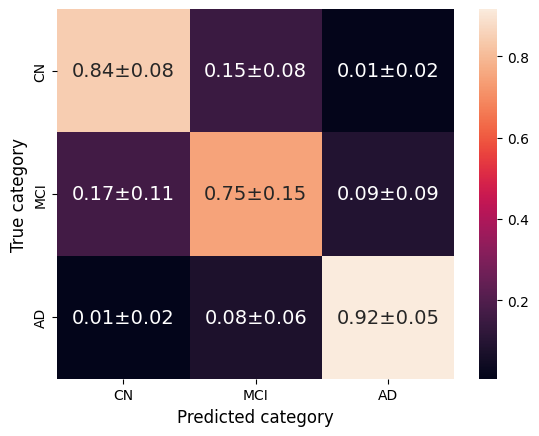

In [ ]:
# Visualize metrics on average confusion matrix
def show_avg_cm(cms, fig_name):
    mean_cm = np.mean(cms, axis=0)
    std_cm = np.std(cms, axis=0)

    # Create annotations matrix
    annotations = np.empty_like(mean_cm, dtype=object)
    for i in range(mean_cm.shape[0]):
        for j in range(mean_cm.shape[1]):
            annotations[i, j] = f"{mean_cm[i, j]:.2f}±{std_cm[i, j]:.2f}"

    cm_labels = ['CN', 'MCI', 'AD']
    sns.heatmap(mean_cm, xticklabels=cm_labels, yticklabels=cm_labels,
                annot=annotations, fmt="", annot_kws={"size": 14})

    plt.xlabel("Predicted category", fontsize=12)
    plt.ylabel("True category", fontsize=12)
    plt.savefig(f'{fig_name}.jpg')
    plt.show()

show_avg_cm(cms, 'dt-all')

In [ ]:
# Train final DT model on train-test split
model_dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=0.05,
    class_weight="balanced",
    random_state=0)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=0.05, random_state=0)

## Fuzzy Logic Rule Induction



In [ ]:
!pip install --quiet ex-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.5 MB/s eta 0:00:00


Total training time: 53.25s
Normalized accuracy: 0.39


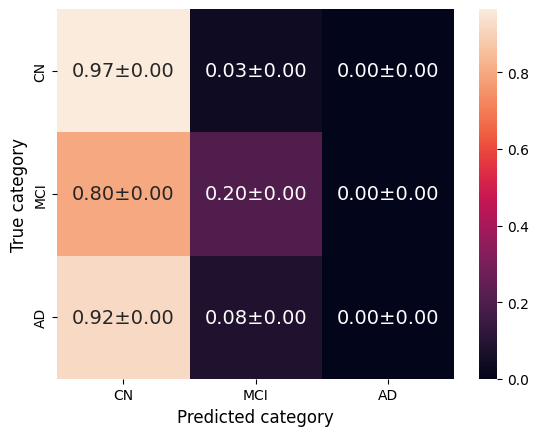

In [ ]:
# Train fuzzy logic model (~5 minutes)
import ex_fuzzy.evolutionary_fit as evf
import ex_fuzzy.eval_tools as eval_tools

t0 = time.time()

# Fit model on train subset
model_fl = evf.BaseFuzzyRulesClassifier(nRules=10, nAnts=7, runner=4)
model_fl.fit(X_train, y_train, n_gen=10, pop_size=30)

# Get predictions on test subset
preds = model_fl.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, preds)
norm_cm = [row / sum(row) for row in cm]
norm_acc = np.mean(np.diag(norm_cm))

print(f"Total training time: {time.time() - t0:.2f}s")
print(f"Normalized accuracy: {norm_acc:.2f}")
show_avg_cm([norm_cm], 'fl-all')

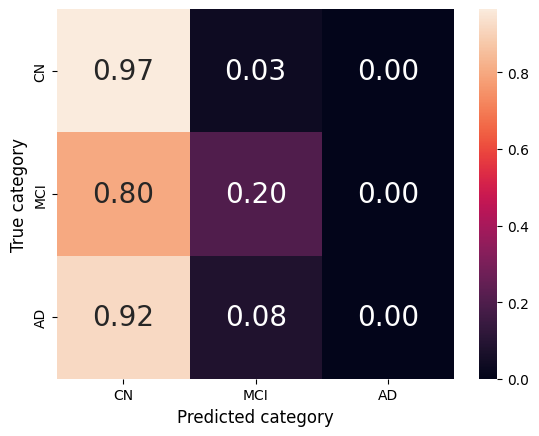

In [ ]:
norm_cm = np.array(norm_cm)
annotations = np.empty_like(norm_cm, dtype=object)
for i in range(norm_cm.shape[0]):
    for j in range(norm_cm.shape[1]):
        annotations[i, j] = f"{norm_cm[i, j]:.2f}"

cm_labels = ['CN', 'MCI', 'AD']
sns.heatmap(norm_cm, xticklabels=cm_labels, yticklabels=cm_labels,
            annot=annotations, fmt="", annot_kws={"size": 20})

plt.xlabel("Predicted category", fontsize=12)
plt.ylabel("True category", fontsize=12)
plt.savefig(f'fl-all.jpg')
plt.show()

## Random Forest

###Hyperparameter search

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def kfold_validation(n_estimators=100, max_depth=5):
    t0 = time.time()
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    accs = list()
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Create and fit model instance
        model_rf = RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            class_weight="balanced",
            random_state=0
        )
        model_rf.fit(
            X.iloc[train_index],
            y.iloc[train_index])

        # Validate results
        preds = model_rf.predict(X.iloc[test_index])
        acc = per_class_accuracy(y.iloc[test_index], preds)
        accs.append(acc)
    return np.mean([np.mean(list(dic.values())) for dic in accs]), time.time() - t0

In [ ]:
# Perform hyperparameter search
parameters = {'n_estimators': [10, 25, 50, 100], 'max_depth': [2, 3, 5, 10]}
performance = perform_hyperparameter_search(
    kfold_validation, 'performance_rf.txt', parameters)

In [ ]:
# Visualize the hyperparameter search
parameters = {'n_estimators': "Number of estimators",
              "max_depth": "Max depth"}
plot_hyperparameter_accuracy(performance, parameters)

In [ ]:
plot_hyperparameter_time(performance, parameters)

The best performing parameter pair is 100 estimators with max depth 3, with a mean training time of 3.27 seconds. The second best performing pair is 50 estimators with max depth 3, with a mean training time of 1.67 seconds.

Given that the time difference is small and only 1 model has to be trained, the combination 100 and 3 will be chosen.

###Metrics

In [ ]:
# KFold validation to extract robust metrics
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    t0 = time.time()
    # Train model on that subset
    clf = RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        class_weight="balanced",
        random_state=0)
    clf.fit(X.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")

Average training time: 0.46 ± 0.09s
Normalized accuracy: 0.86 ± 0.05


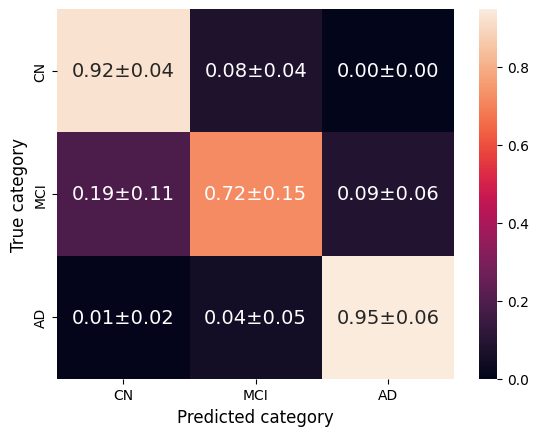

In [ ]:
show_avg_cm(cms, 'rf-all')

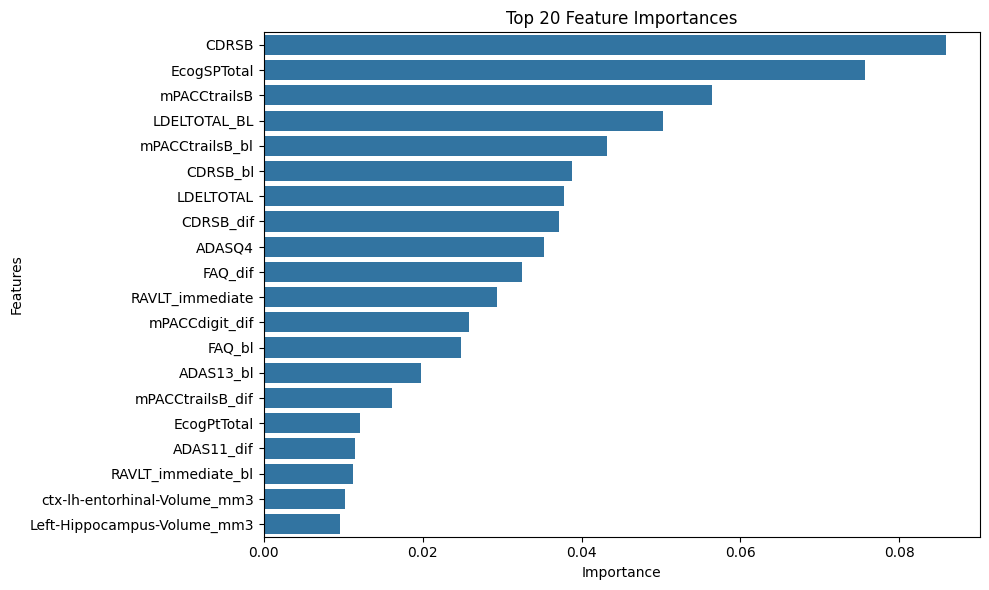

In [ ]:
# Global feature importance
model_rf = RandomForestClassifier(
    max_depth=5,
    n_estimators=100,
    class_weight="balanced",
    random_state=0)
model_rf.fit(X, y)

keys = list(X.columns)
columns = list()
for col in keys:
    if col.startswith("aseg") or col.startswith("cereb"):
        columns.append(col.split("stats-")[1])
    else:
        columns.append(col)
columns = np.array(columns)
values = model_rf.feature_importances_
sorted_scores = np.argsort(values)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(y=columns[sorted_scores][:20], x=values[sorted_scores][:20])

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig("feat-imp-rf.jpg")
plt.show()

In [ ]:
# Train final RF model on train-test split
model_rf = RandomForestClassifier(
    max_depth=5,
    n_estimators=100,
    class_weight="balanced",
    random_state=0)
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=0)

## XGBoost


### Hyperparameter search

In [ ]:
import xgboost as xgb

def kfold_validation(n_estimators=10, max_depth=5):
    t0 = time.time()
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    accs = list()
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # compute class weights for the fold
        classes_weights = class_weight.compute_sample_weight(
            class_weight='balanced',
            y=y.iloc[train_index]
        )

        # create and fit model instance
        bst = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            objective='multi:softmax')

        bst.fit(
            X.iloc[train_index],
            y.iloc[train_index],
            sample_weight=classes_weights)

        # validate results
        preds = bst.predict(X.iloc[test_index])
        acc = per_class_accuracy(y.iloc[test_index], preds)
        accs.append(acc)
    return np.mean([np.mean(list(dic.values())) for dic in accs]), time.time() - t0

In [ ]:
# Hyperparameter tuning
parameters = {'n_estimators': [10, 25, 50, 100], 'max_depth': [2, 3, 5, 10]}
performance = perform_hyperparameter_search(
    kfold_validation, 'performance_xgb.txt', parameters)

In [ ]:
# Visualize the hyperparameter search
parameters = {'n_estimators': "Number of Estimators", "max_depth": "Max Depth"}
plot_hyperparameter_accuracy(performance, parameters)

In [ ]:
plot_hyperparameter_time(performance, parameters)

The number of estimators maximizes at around 25 to 50, while the max depth seems to relate directly to the performance of the model, with the best performing pairs being (10, 50), (5, 25) and (5, 50). The combination with the lowest mean training time of the optimal region is (5, 25), with 12.2s, compared to the highest mean training time of (10, 50), with 17.7s.

Given that time saved is small and only 1 model has to be trained, the chosen combination is the best performing: max depth 10 and 50 estimators, with a normalized accuracy of 0.876.

###Metrics

In [ ]:
# KFold validation to extract robust metrics
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    t0 = time.time()
    # Compute class weights
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )
    # Train model on that subset
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=5,
        objective='multi:softmax')
    bst.fit(
        X.iloc[train_index],
        y.iloc[train_index],
        sample_weight=classes_weights)

    # Get predictions on test subset
    preds = bst.predict(X.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")

Average training time: 1.59 ± 1.01s
Normalized accuracy: 0.88 ± 0.05


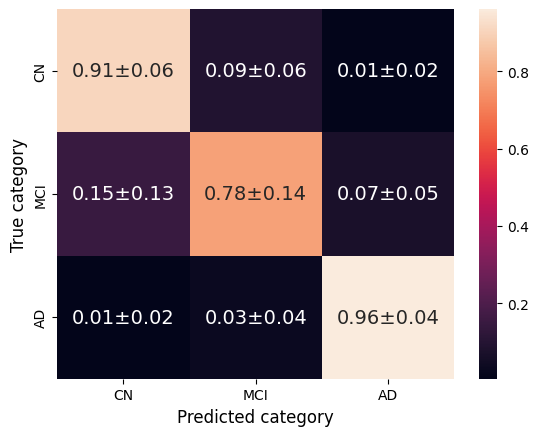

In [ ]:
show_avg_cm(cms, 'xgb-all')

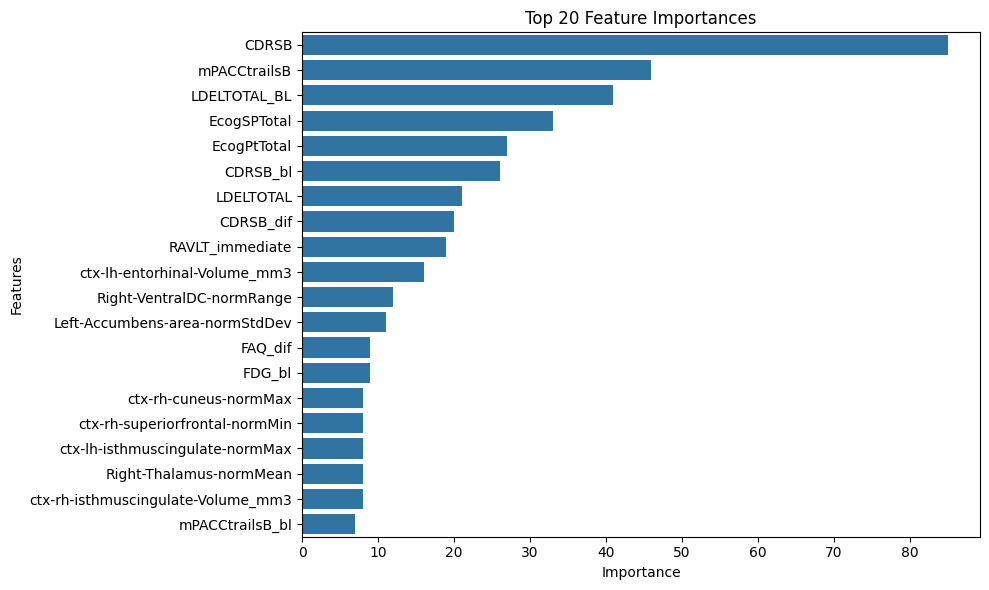

In [ ]:
# Global feature importance
model_xgb = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    objective='multi:softmax')
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced', y=y
)
model_xgb.fit(X, y, sample_weight=classes_weights)

feature_important = model_xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
columns = list()
for col in keys:
    if col.startswith("aseg") or col.startswith("cereb"):
        columns.append(col.split("stats-")[1])
    else:
        columns.append(col)
columns = np.array(columns)
values = np.array(list(feature_important.values()))
sorted_scores = np.argsort(values)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(y=columns[sorted_scores][:20], x=values[sorted_scores][:20])

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig("feat-imp-xgb.jpg")
plt.show()

In [ ]:
# Train final XGB model on train-test split
model_xgb = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    objective='multi:softmax')
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced', y=y_train
)
model_xgb.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

# Ablation Study

Train every model for kfolds and extract CM mean and std on the following data subsets:

- All data types
- Only imaging data (+ biomarkers and general)
- Only cognitive test data (+ biomarkers and general)

In [ ]:
# Imaging data
imaging = [
    'Ventricles', 'Entorhinal', 'WholeBrain', 'Hippocampus','Fusiform',
    'MidTemp', 'ICV']

imaging_feats = list()
for feature_name in X_train.columns:
    if feature_name.lower().endswith("_bl"):
        name = feature_name[:-3]
    elif feature_name.endswith("_dif"):
        name = feature_name[:-4]
    else:
        name = feature_name

    if (name in imaging) or name.startswith("aseg") or name.startswith("cereb"):
        imaging_feats.append(feature_name)

X_img = X[imaging_feats]

In [ ]:
# Cognitive tests
cognitive_scores = [
    'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
    'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
    'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ',
    'MOCA', 'mPACCdigit', 'mPACCtrailsB', 'EcogSPTotal', 'EcogPtTotal']

cogn_feats = list()
for feature_name in X_train.columns:
    if feature_name.lower().endswith("_bl"):
        name = feature_name[:-3]
    elif feature_name.endswith("_dif"):
        name = feature_name[:-4]
    else:
        name = feature_name

    if name in cognitive_scores:
        cogn_feats.append(feature_name)

X_cog = X[cogn_feats]

In [ ]:
# Biomarkers, genetics and general
genetics_biomarkers = [
    'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU']
general = ['AGE', 'PTEDUCAT']

misc_feats = list()
for feature_name in X_train.columns:
    if feature_name.lower().endswith("_bl"):
        name = feature_name[:-3]
    elif feature_name.endswith("_dif"):
        name = feature_name[:-4]
    else:
        name = feature_name

    if (name in genetics_biomarkers) or (name in general):
        misc_feats.append(feature_name)

X_mis = X[misc_feats]
X_img_mis = pd.concat([X_img, X_mis], axis=1)
X_cog_mis = pd.concat([X_cog, X_mis], axis=1)

## Imaging data

Decision Tree: only imaging data
Average training time: 0.05 ± 0.00s
Normalized accuracy: 0.49 ± 0.05


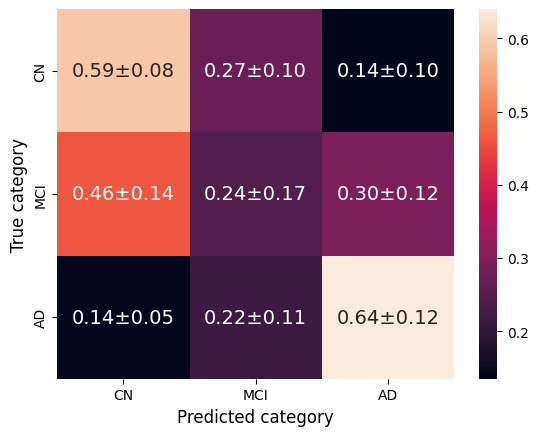

In [ ]:
# Decision Tree (only imaging)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img, y)):
    t0 = time.time()
    # Train model on that subset
    clf = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=0.05,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_img.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_img.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Decision Tree: only imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'dt-img')

Decision Tree: imaging data + misc
Average training time: 0.06 ± 0.01s
Normalized accuracy: 0.55 ± 0.04


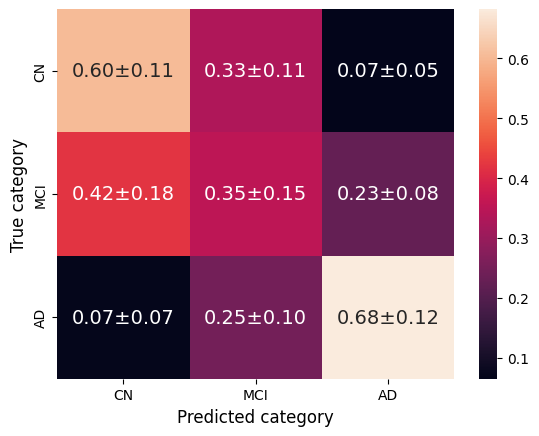

In [ ]:
# Decision Tree (imaging + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img_mis, y)):
    t0 = time.time()
    # Train model on that subset
    clf = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=0.05,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_img_mis.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_img_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Decision Tree: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'dt-img+misc')

Random Forest: imaging data
Average training time: 0.56 ± 0.11s
Normalized accuracy: 0.57 ± 0.06


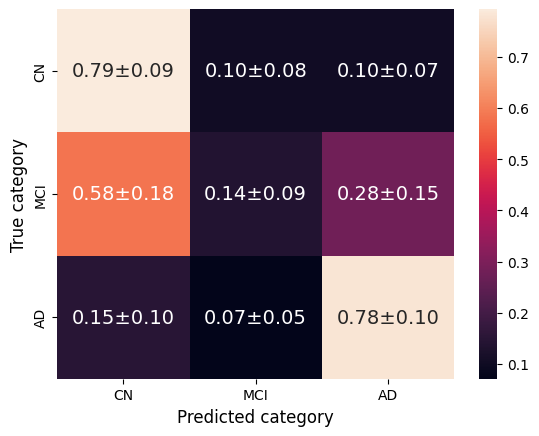

In [ ]:
# Random Forest (only imaging)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img, y)):
    t0 = time.time()
    # Train model on that subset
    clf = RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_img.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_img.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Random Forest: imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'rf-img')

Random Forest: imaging data + misc
Average training time: 0.42 ± 0.01s
Normalized accuracy: 0.62 ± 0.07


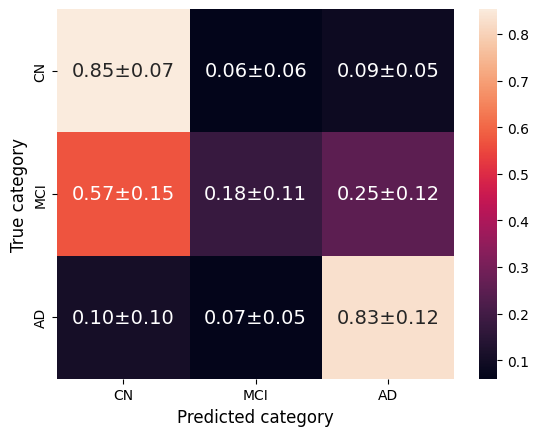

In [ ]:
# Random Forest (imaging + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img_mis, y)):
    t0 = time.time()
    # Train model on that subset
    clf = RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_img_mis.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_img_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Random Forest: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'rf-img+misc')

XGBoost: imaging data
Average training time: 2.46 ± 1.34s
Normalized accuracy: 0.59 ± 0.07


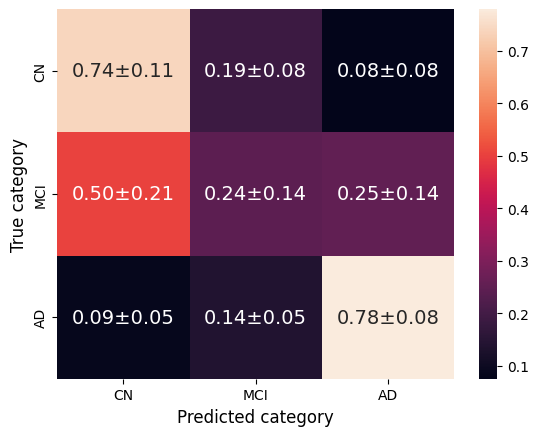

In [ ]:
# XGBoost (imaging data)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img, y)):
    t0 = time.time()
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )
    # Train model on that subset
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=5,
        objective='multi:softmax')
    bst.fit(
        X_img.iloc[train_index],
        y.iloc[train_index],
        sample_weight=classes_weights)

    # Get predictions on test subset
    preds = bst.predict(X_img.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("XGBoost: imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'xgb-img')

XGBoost: imaging data + misc
Average training time: 2.07 ± 0.73s
Normalized accuracy: 0.60 ± 0.06


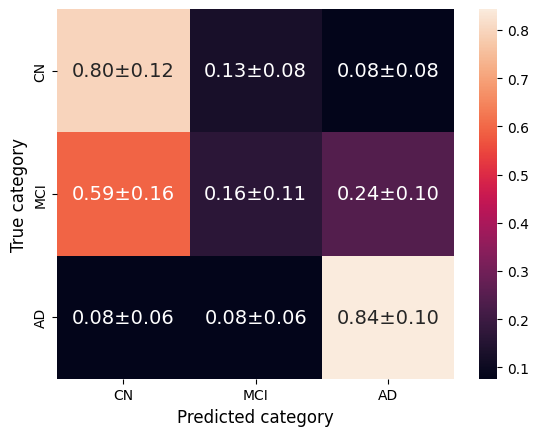

In [ ]:
# XGBoost (imaging data + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_img_mis, y)):
    t0 = time.time()
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )
    # Train model on that subset
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=5,
        objective='multi:softmax')
    bst.fit(X_img_mis.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = bst.predict(X_img_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("XGBoost: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'xgb-img+misc')

##Cognitive tests

Decision Tree: only imaging data
Average training time: 0.01 ± 0.00s
Normalized accuracy: 0.85 ± 0.04


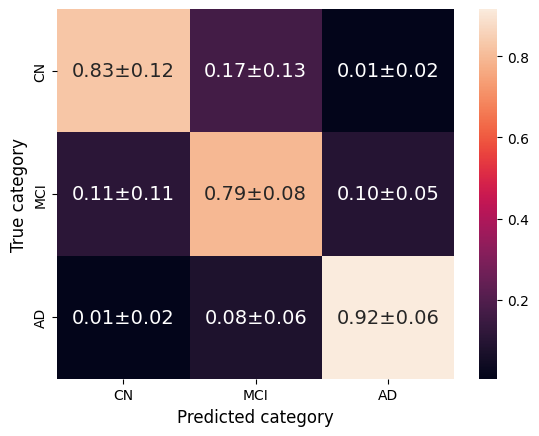

In [ ]:
# Decision Tree (only imaging)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog, y)):
    t0 = time.time()
    # Train model on that subset
    clf = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=0.05,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_cog.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_cog.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Decision Tree: only imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'dt-cog')

Decision Tree: imaging data + misc
Average training time: 0.01 ± 0.00s
Normalized accuracy: 0.84 ± 0.05


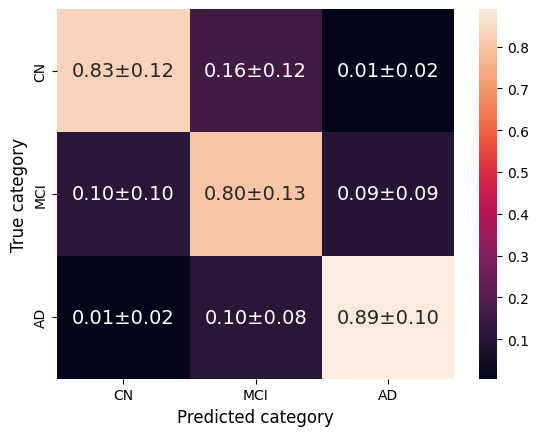

In [ ]:
# Decision Tree (imaging + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog_mis, y)):
    t0 = time.time()
    # Train model on that subset
    clf = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=0.05,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_cog_mis.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_cog_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Decision Tree: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'dt-cog+misc')

Random Forest: imaging data
Average training time: 0.30 ± 0.06s
Normalized accuracy: 0.88 ± 0.05


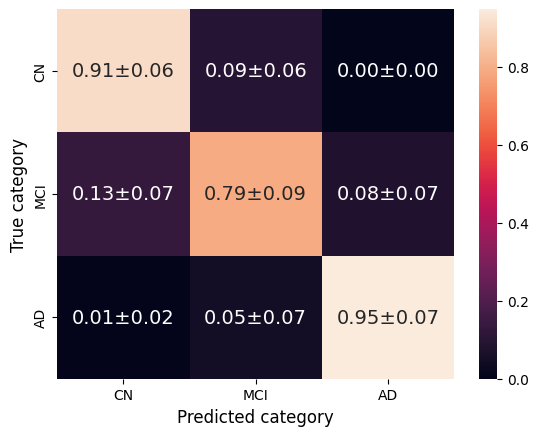

In [ ]:
# Random Forest (only imaging)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog, y)):
    t0 = time.time()
    # Train model on that subset
    clf = RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_cog.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_cog.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Random Forest: imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'rf-cog')

Random Forest: imaging data + misc
Average training time: 0.35 ± 0.06s
Normalized accuracy: 0.88 ± 0.04


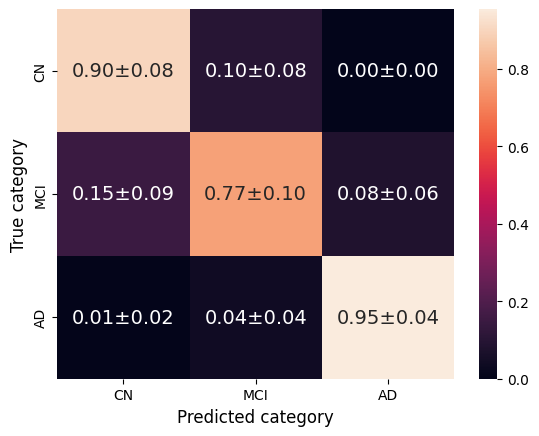

In [ ]:
# Random Forest (imaging + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog_mis, y)):
    t0 = time.time()
    # Train model on that subset
    clf = RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        class_weight="balanced",
        random_state=0)
    clf.fit(X_cog_mis.iloc[train_index], y.iloc[train_index])

    # Get predictions on test subset
    preds = clf.predict(X_cog_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("Random Forest: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'rf-cog+misc')

XGBoost: imaging data
Average training time: 0.15 ± 0.01s
Normalized accuracy: 0.87 ± 0.06


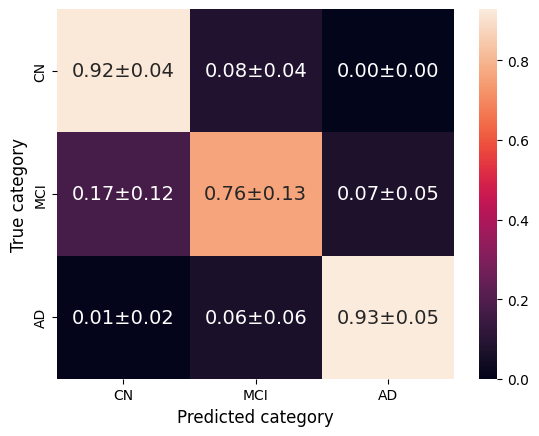

In [ ]:
# XGBoost (imaging data)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog, y)):
    t0 = time.time()
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )
    # Train model on that subset
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=5,
        objective='multi:softmax')
    bst.fit(
        X_cog.iloc[train_index],
        y.iloc[train_index],
        sample_weight=classes_weights)

    # Get predictions on test subset
    preds = bst.predict(X_cog.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("XGBoost: imaging data")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'xgb-cog')

XGBoost: imaging data + misc
Average training time: 0.19 ± 0.02s
Normalized accuracy: 0.87 ± 0.04


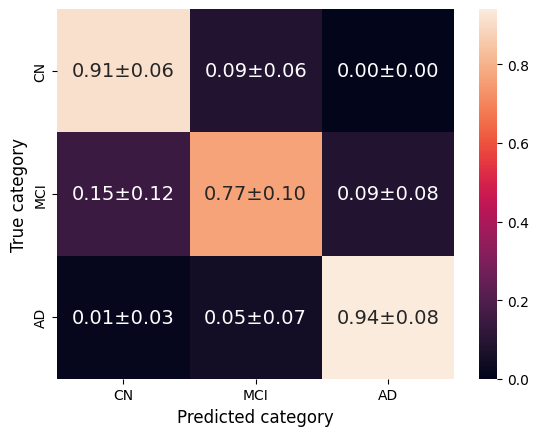

In [ ]:
# XGBoost (imaging data + misc)
kf = StratifiedKFold(n_splits=10, shuffle=True)

cms, times = list(), list()
for i, (train_index, test_index) in enumerate(kf.split(X_cog_mis, y)):
    t0 = time.time()
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y.iloc[train_index]
    )
    # Train model on that subset
    bst = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=5,
        objective='multi:softmax')
    bst.fit(
        X_cog_mis.iloc[train_index],
        y.iloc[train_index],
        sample_weight=classes_weights)

    # Get predictions on test subset
    preds = bst.predict(X_cog_mis.iloc[test_index])

    # Save confusion matrix and time
    cm = confusion_matrix(y.iloc[test_index], preds)
    norm_cm = [row / sum(row) for row in cm]
    cms.append(norm_cm)
    times.append(time.time() - t0)

print("XGBoost: imaging data + misc")
print(f"Average training time: {np.mean(times):.2f} ± {np.std(times):.2f}s")
norm_accs = list()
for cm in cms:
    norm_acc = np.mean(np.diag(cm))
    norm_accs.append(norm_acc)
print(f"Normalized accuracy: {np.mean(norm_accs):.2f} ± {np.std(norm_accs):.2f}")
show_avg_cm(cms, 'xgb-cog+misc')

# Interpretation

Each model has its own interpretation tools:

*   Decision Tree: extract a graph plot with the exact trained tree in SVG format.
*   Fuzzy Logic: extract exact rules in natural language and graph format.
*   Random Forest and XGBoost: obtain most important features for each patient and category.



##Decision Tree

In [ ]:
# Visualize DT for interpretation
from sklearn.tree import export_graphviz
from matplotlib.colors import to_rgb, to_hex
import graphviz
import re

# Create blend of 3 colors according to weights
def blend_hex_colors(hex_colors, weights):
    # convert each hex → (r,g,b) tuple in [0,1]
    rgbs = [to_rgb(c) for c in hex_colors]
    # weighted sum
    blended = (
        sum(w * rgb[0] for w,rgb in zip(weights, rgbs)),
        sum(w * rgb[1] for w,rgb in zip(weights, rgbs)),
        sum(w * rgb[2] for w,rgb in zip(weights, rgbs)),
    )
    # back to hex
    return to_hex(blended)

# Export dot data
dot_data = export_graphviz(
    model_dt,
    out_file=None,
    feature_names=[describe_feature(feat) for feat in X.columns],
    class_names=list(cat_map.values()),
    filled=True,
    rounded=True,
    special_characters=True,
)

# Define class colors
class_colors = ['#6BF178','#FFE74C','#FF5964']

# Match node colors and replace
pattern = re.compile(r'value = \[([0-9.0-9,\s]+)\].*?fillcolor="[^"]+"', re.S)
def replace_node(match):
    idx_start = match.group(0).find('<br/>class = ')
    idx_final = match.group(0).find('>,')
    vals = [float(x) for x in match.group(1).split(',')]
    vals = np.array(vals) / np.sum(vals)
    col = blend_hex_colors(class_colors, vals)
    res = f'value = [{match.group(1)}]' + match.group(0)[idx_start:idx_final+2] + f'fillcolor="{col}"'
    return res

dot_data_custom = pattern.sub(replace_node, dot_data)

# 5. Render it
graph = graphviz.Source(dot_data_custom)
graph.render("decision_tree", format='svg')  # Generates PDF/SVG file

'decision_tree.svg'

In [ ]:
# Save sample specific decision paths
ordinals = ["First", "Second", "Third", "Fourth", "Fifth", "Sixth"]
def write_decision_paths_to_file(clf, X, filename="decision_path.txt"):

    # compute decision paths and leaves for all samples
    node_indicator = clf.decision_path(X)
    leaf_ids = clf.apply(X)
    feature_names = X.columns

    for sample_id, idx in enumerate(X.index):
        patient_id = metadata[metadata.index == idx]['PTID'].iloc[0]
        res_path = os.path.join(path, f"results/{patient_id}/")
        os.makedirs(path, exist_ok=True)

        # extract the nodes involved for this sample
        start, end = node_indicator.indptr[sample_id], node_indicator.indptr[sample_id + 1]
        node_index = node_indicator.indices[start:end]

        # build path description
        steps = []
        for order_id, node_id in enumerate(node_index):
            # leaf node
            if node_id == leaf_ids[sample_id]:
                counts = clf.tree_.value[node_id][0]
                probs = [f'{cat_map[i]}: {prob*100:.1f}%' for i, prob in enumerate(counts) if prob > 0]
                predicted = cat_map[np.argmax(counts)]
                steps.append(f"Prediction: {predicted},\tProbabilities: {', '.join(probs)}")
                break

            # internal node
            feature = clf.tree_.feature[node_id]
            threshold = clf.tree_.threshold[node_id]
            name = feature_names[feature]
            val = X.loc[idx, name]
            name = describe_feature(name)
            decision = 'True' if val <= threshold else 'False'
            direction = 'left' if val <= threshold else 'right'
            steps.append(
                f"{ordinals[order_id]} decision: Is {name} lower than {threshold:.3f}? {decision} ({val:.3f}) -> Go to {direction} branch."
            )

        # write path
        with open(res_path + filename, 'w') as f:
            line = ";".join(steps)
            f.write(line)

    print(f"Decision paths for {X.shape[0]} samples written to '{filename}'")

write_decision_paths_to_file(model_dt, pd.concat([X_train, X_test]))

Decision paths for 453 samples written to 'decision_path.txt'


##Random Forest and XGBoost

Craft additional info from the features

In [ ]:
# Normalize importance weights conserving positive and negative values
def norm_pos_neg(shap_values):
    neg = shap_values < 0
    pos = shap_values > 0

    # Normalize positive values
    shap_values[pos] = ((shap_values[pos] - np.min(shap_values[pos]))
      / (np.max(shap_values[pos]) - np.min(shap_values[pos])))

    # Normalize negative values
    shap_values[neg] = ((shap_values[neg] - np.min(shap_values[neg]))
      / (np.max(shap_values[neg]) - np.min(shap_values[neg])) - 1)
    return shap_values


In [ ]:
import shap
shap.initjs()

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_xgb = explainer_xgb.shap_values(X)
shap_xgb = norm_pos_neg(shap_xgb)
preds_xgb = model_xgb.predict_proba(X)

explainer_rf = shap.TreeExplainer(model_rf)
shap_rf = explainer_rf.shap_values(X)
shap_rf = norm_pos_neg(shap_rf)
preds_rf = model_rf.predict_proba(X)

In [ ]:
from scipy import stats

# Get feature percentil
def feature_percentil(feature_name, value):
    distr = data[feature_name]
    return stats.percentileofscore(distr, value)

# Get feature group
def get_group(feature_name):
    # Clean feature name
    if feature_name.lower().endswith("_bl"):
        feature_name = feature_name[:-3]
    elif feature_name.endswith("_dif"):
        feature_name = feature_name[:-4]
    # Imaging data
    imaging = [
        'Ventricles', 'Entorhinal', 'WholeBrain', 'Hippocampus','Fusiform',
        'MidTemp', 'ICV']
    if (feature_name in imaging) or (feature_name.startswith("aseg")) or \
          (feature_name.startswith("cereb")):
        return "MRI & PET Imaging Data"

    # Cognitive scores
    cognitive_scores = [
        'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE',
        'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
        'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ',
        'MOCA', 'mPACCdigit', 'mPACCtrailsB', 'EcogSPTotal', 'EcogPtTotal']
    if feature_name in cognitive_scores:
        return "Cognitive Scores"

    # Genetics and biomarkers
    genetics_biomarkers = [
        'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU']
    if feature_name in genetics_biomarkers:
        return "Genetics & Biomarkers"

    # General
    general = ['AGE', 'PTEDUCAT']
    if feature_name in general:
        return "General"

    return 'None'


In [ ]:
# Get most relevant features and translate them into natural language

def extract_explanations_df(X, shap_xgb, shap_rf, pred):
    shap_xgb = shap_xgb[:,pred]
    shap_rf = shap_rf[:,pred]

    expl = list()
    for i, (weight_xgb, weight_rf) in enumerate(zip(shap_xgb, shap_rf)):
        feature_name = X.index[i]
        try:
          sample = {
              'feature': feature_name,
              'name': describe_feature(feature_name),
              'value': X[feature_name],
              'importance-xgboost': weight_xgb,
              'importance-rf': weight_rf,
              'percentile': feature_percentil(feature_name, X[feature_name]),
              'group': get_group(feature_name)
          }
        except:
          print(feature_name)
          raise AssertionError()
        expl.append(sample)
    return pd.DataFrame(expl)


def get_full_patient_summary(X, idx, shap_xgb, shap_rf):
    sample = X.iloc[idx]
    shap_xgb = shap_xgb[idx,:,:]
    shap_rf = shap_rf[idx,:,:]
    for pred in [0,1,2]:
        if pred == 0:
            explanations_cn = extract_explanations_df(sample, shap_xgb, shap_rf, pred)
        elif pred == 1:
            explanations_mci = extract_explanations_df(sample, shap_xgb, shap_rf, pred)
        else:
            explanations_ad = extract_explanations_df(sample, shap_xgb, shap_rf, pred)
    return explanations_cn, explanations_mci, explanations_ad


# Example
idx = 0
explanations_cn, explanations_mci, explanations_ad = get_full_patient_summary(X, idx, shap_xgb, shap_rf)

In [ ]:
# Save explanations for each category with the probabilities
# on the folder of the patient
import os

for pos, idx in enumerate(X.index):
    # Get patient identifier
    patient_id = metadata[metadata.index == idx]['PTID'].iloc[0]

    # Create patient folder
    res_path = os.path.join(path, f"results/{patient_id}/")
    os.makedirs(path, exist_ok=True)

    # Get probabilities and explanations
    probs_xgb = np.exp(preds_xgb[pos])/sum(np.exp(preds_xgb[pos]))
    probs_rf  = np.exp(preds_rf[pos] )/sum(np.exp(preds_rf[pos]) )
    explanations_cn, explanations_mci, explanations_ad = \
      get_full_patient_summary(X, pos, shap_xgb, shap_rf)

    # Save into the folder
    with open(res_path + f"xgboost-probs.txt", 'w') as f:
        f.write(f"{probs_xgb[0]}\t{probs_xgb[1]}\t{probs_xgb[2]}\n")
    with open(res_path + f"rf-probs.txt", 'w') as f:
        f.write(f"{probs_rf[0]}\t{probs_rf[1]}\t{probs_rf[2]}\n")

    explanations_cn.to_csv(res_path + f'explanations-cn.csv', index=False)
    explanations_mci.to_csv(res_path + f'explanations-mci.csv', index=False)
    explanations_ad.to_csv(res_path + f'explanations-ad.csv', index=False)